In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_air_polution_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    drop_null_rows,
)

from src.evaluation import evaluate

In [25]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [26]:
dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="date")
    .pipe(set_index, col="date")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_Data, freq="D")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (1825, 7)
dataframe shape (1825, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Freq: D
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1825 non-null   float64
 1   dewp       1825 non-null   float64
 2   temp       1825 non-null   float64
 3   press      1825 non-null   float64
 4   wnd_spd    1825 non-null   float64
 5   snow       1825 non-null   float64
 6   rain       1825 non-null   float64
dtypes: float64(7)
memory usage: 114.1 KB
None


,pollution,dewp,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0


In [27]:
dataframe.isna().sum().sum()

0

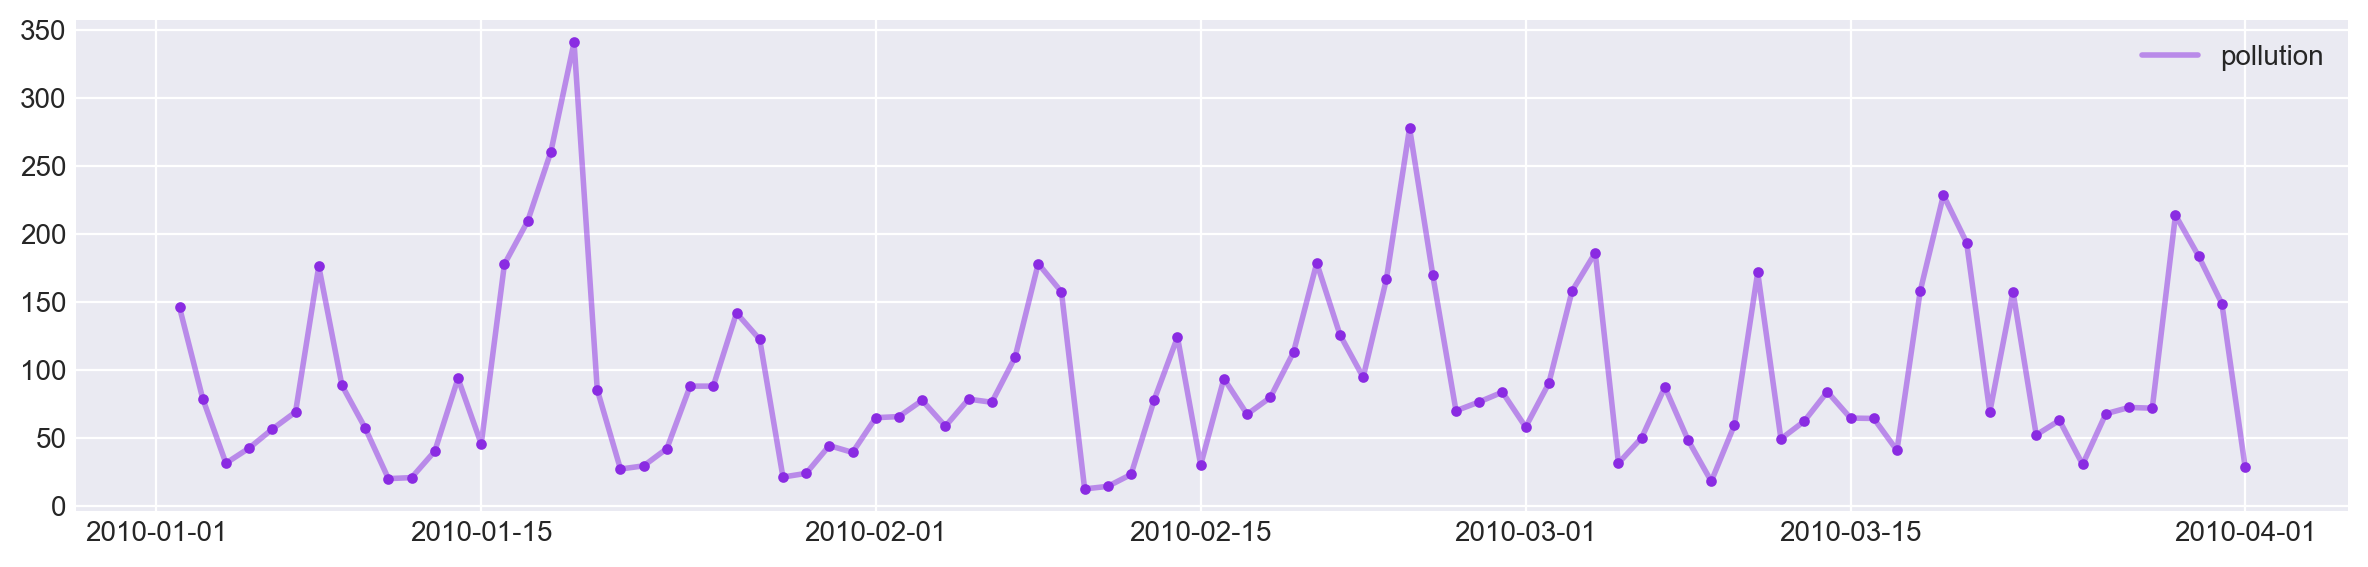

In [28]:
show_dataset(dataframe[:90], columns=["pollution"])

In [29]:
DT_FEATURES = ['month', 'quarter', 'semester', 'year', 'week', 'day_of_week', 'day_of_month', 
               'day_of_year', 'weekend', 'month_start', 'month_end', 'quarter_start', 'quarter_end', 
               'year_start', 'year_end']
CYCLIC_FEATURE = ["day_of_week","day_of_month", "day_of_year", "week",'month','quarter','year']
LAGS = [1, 2]
FEATURE_WINDOW_LEN = 3

TARGET_COLUMN = "pollution"
TEST_SIZE = 30

In [30]:
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures, ExpandingWindowFeatures
from feature_engine.selection import DropConstantFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from sklearn.pipeline import Pipeline

from sklearn.compose import TransformedTargetRegressor

CYCLIC_FEATURE = ['month', 'quarter', 'semester', 'year', 'week', 'day_of_week', 'day_of_month', 
           'day_of_year', 'weekend', 'month_start', 'month_end', 'quarter_start', 
           'quarter_end', 'year_start', 'year_end']

preprocessor_ = Pipeline(
    [
        ("LagFeatures", LagFeatures(variables=dataframe.columns.to_list(), 
                               freq=["1D", "2D", "3D"])
        ),
        ("WindowFeature", WindowFeatures(variables=dataframe.columns.to_list(),
                                         functions=["mean", "std", "skew"],
                                         window=[3, 4 ],
                                         periods=1)
        ),
        (
          "ExpandingWindowFeatures", ExpandingWindowFeatures(variables=["pollution"], 
                                                             functions=["mean", "std", "skew","min","max"],
                                                             periods=1) 
        ),
        (
            "DatetimeFeatures", DatetimeFeatures(variables="index",  features_to_extract=CYCLIC_FEATURE)
        ),
        (
            'cyclical', CyclicalFeatures(variables=CYCLIC_FEATURE),
        ),
        #(
        #    "constant_feat_drop", DropConstantFeatures()
        #)
        
    ]
)

print(f"dataframe shape {dataframe.shape}")

dataframe_p = preprocessor_.fit_transform(dataframe)
print(f"dataframe shape {dataframe_p.shape}")

dataframe_p.dropna(axis=0, inplace=True)

print(f"dataframe shape {dataframe_p.shape}")

#dataframe_p

dataframe shape (1825, 7)
dataframe shape (1825, 120)
dataframe shape (1821, 120)


In [31]:



print(f"dataframe shape after Feature Union {dataframe_p.shape}", end="\n\n")

train_data, test_data = test_train_split(dataframe_p, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ", end="\n\n")

train_x, train_y = seperate_target(train_data, TARGET_COLUMN)
test_x, test_y = seperate_target(test_data, TARGET_COLUMN)

print(f"train_x shape after seperate_target {train_x.shape}")
print(f"train_y shape after seperate_target {train_y.shape}")
print(f"test_x  shape after seperate_target {test_x.shape}")
print(f"test_y  shape after seperate_target {test_y.shape}")

dataframe shape after Feature Union (1821, 120)

Train Size after Test_Train Split: (1791, 120)
Test  Size after Test_Train Split: (30, 120) 

train_x shape after seperate_target (1791, 119)
train_y shape after seperate_target (1791, 1)
test_x  shape after seperate_target (30, 119)
test_y  shape after seperate_target (30, 1)


In [32]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [37]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12,13, 15,18]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat
print(resultsDict)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END .........regressor__n_neighbors=2;, score=-0.244 total time=   0.0s
[CV 2/3] END .........regressor__n_neighbors=2;, score=-0.193 total time=   0.0s
[CV 3/3] END .........regressor__n_neighbors=2;, score=-0.003 total time=   0.0s
[CV 1/3] END .........regressor__n_neighbors=3;, score=-0.090 total time=   0.0s
[CV 2/3] END .........regressor__n_neighbors=3;, score=-0.092 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.112 total time=   0.0s
[CV 1/3] END .........regressor__n_neighbors=5;, score=-0.007 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.003 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.165 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.055 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.076 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

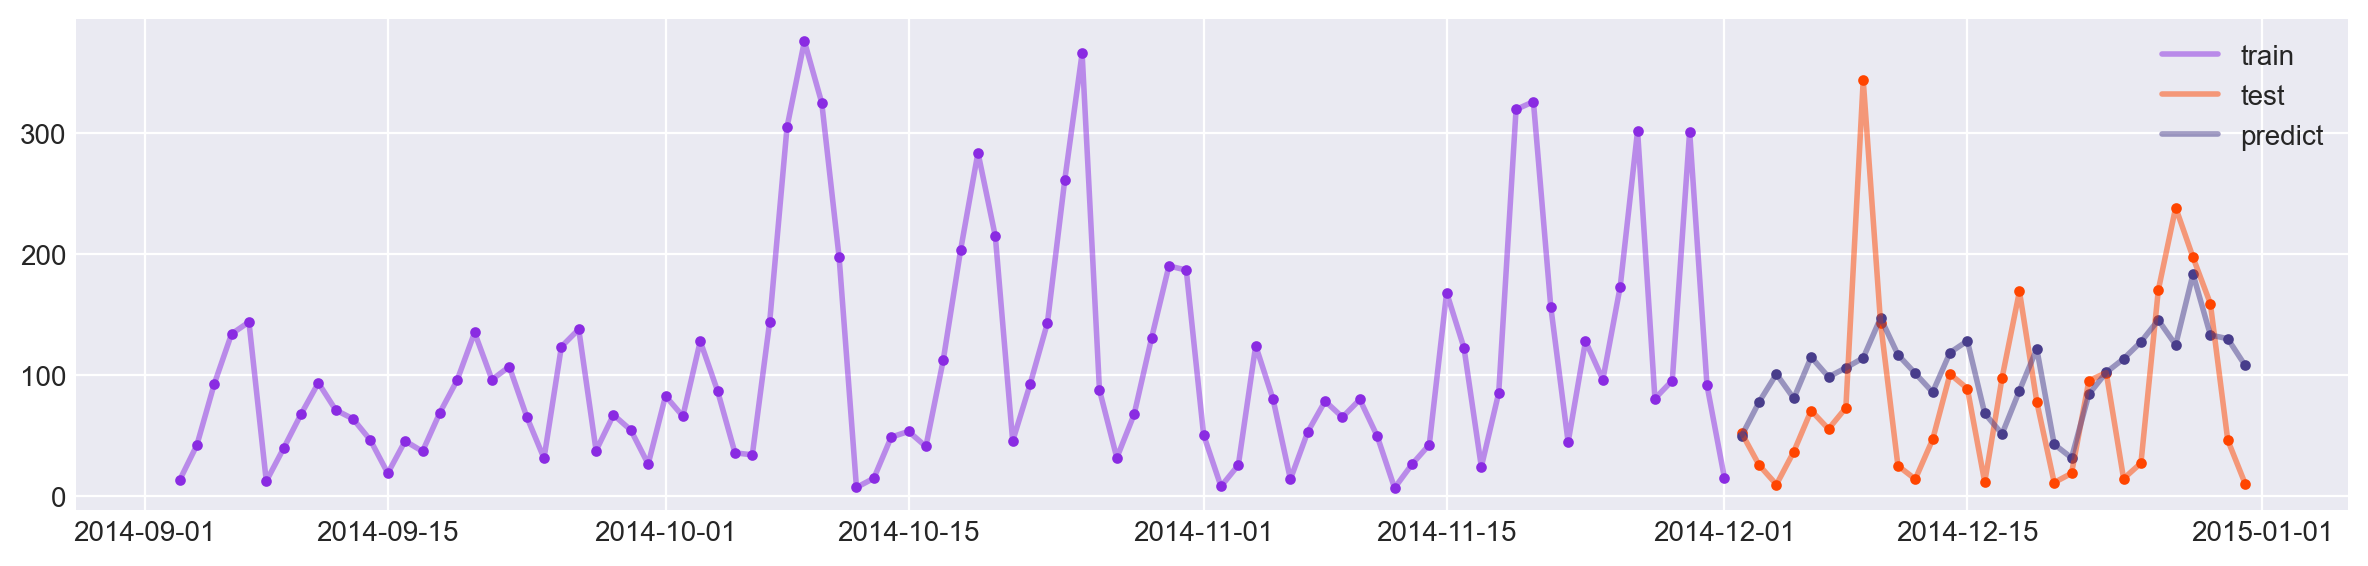

In [38]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [40]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat
print(resultsDict)

Convergence after  11  iterations
{'KNeighborsRegressor': {'mae': 55.54490740740741, 'rmse': 72.31146960033105, 'mape': 2.0304819219241006, 'r2': 0.14060948018817976}, 'BayesianRidge': {'mae': 37.82580443165425, 'rmse': 54.59979563674633, 'mape': 1.1355902393753752, 'r2': 0.510042717574813}}


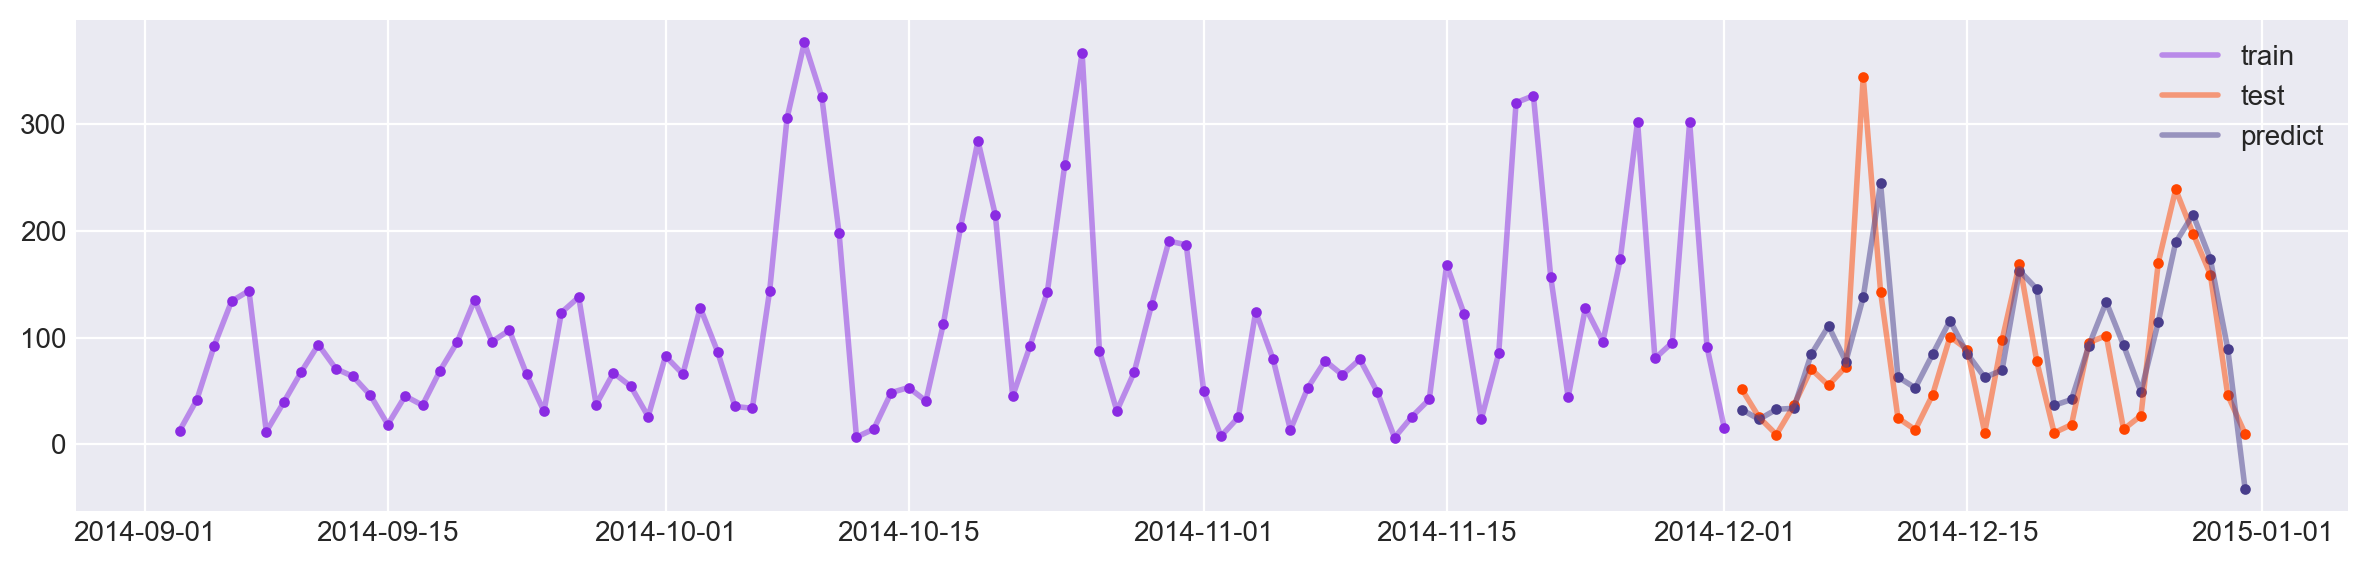

In [41]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

<Axes: >

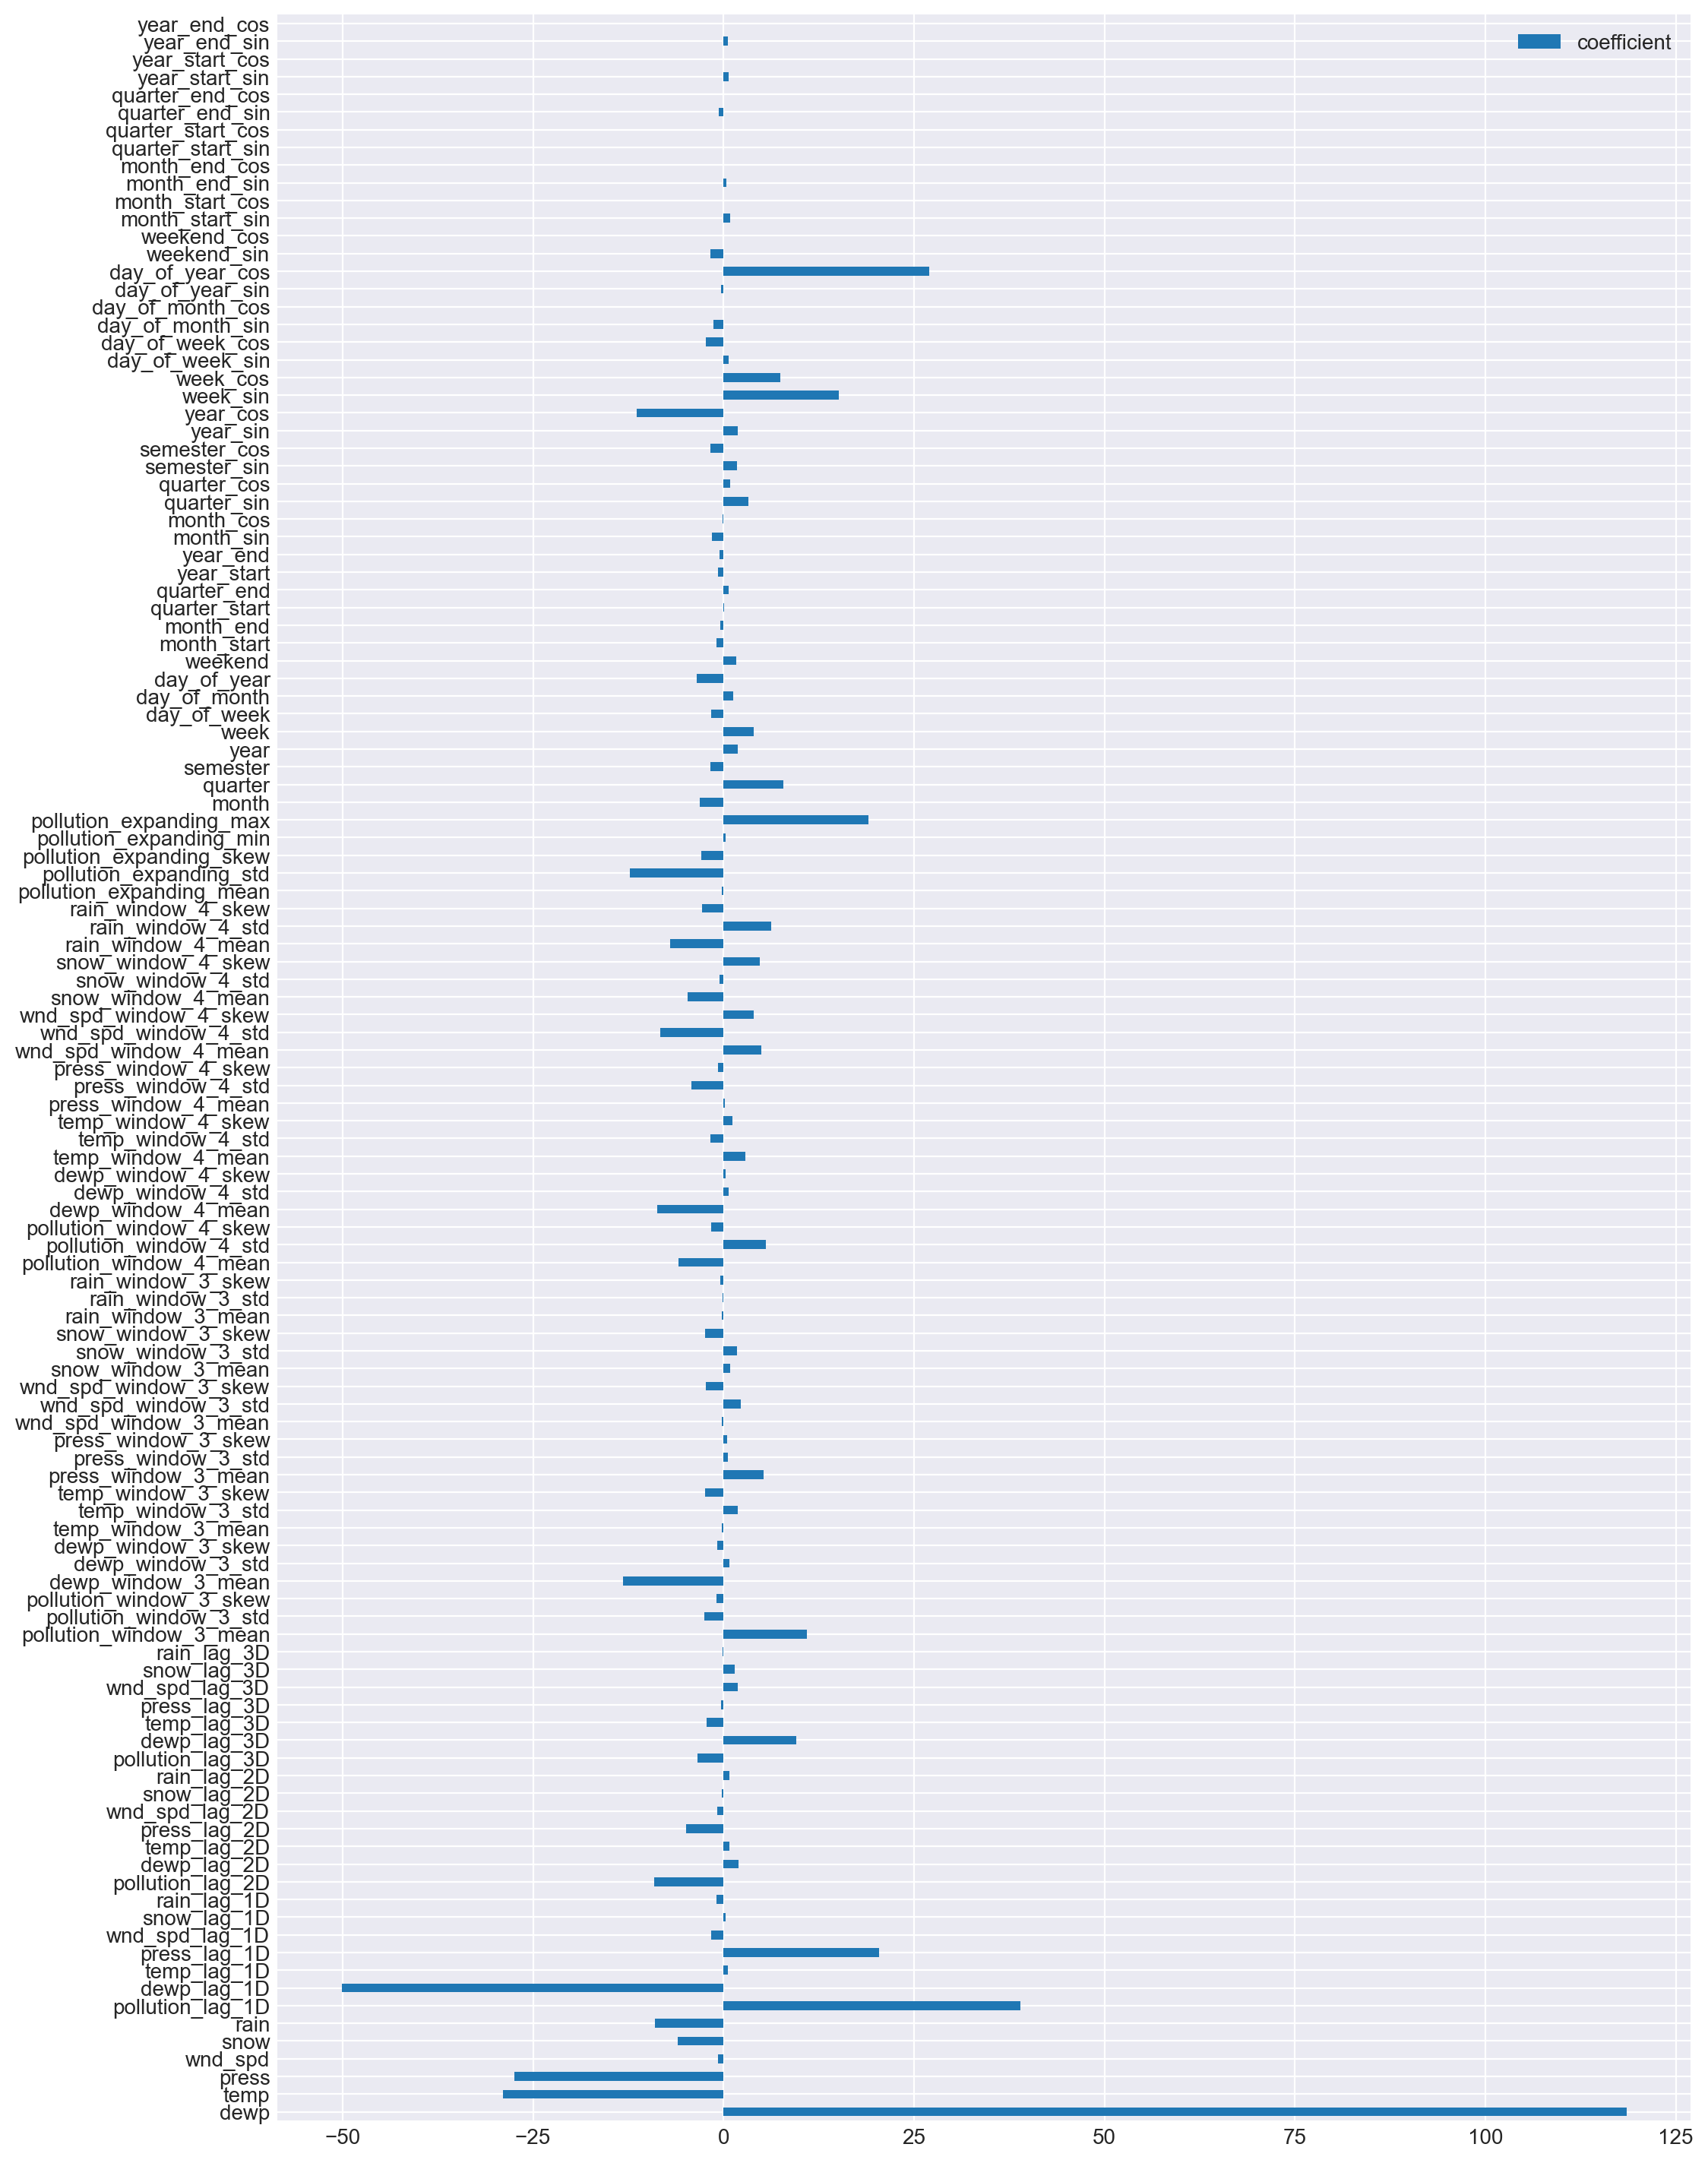

In [42]:

pd.DataFrame(model[1].coef_, train_x.columns, columns=['coefficient']).plot(kind='barh', figsize=(12,18))

### LassoCV Regressor

In [43]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True, max_iter=100000))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

print(resultsDict)

{'KNeighborsRegressor': {'mae': 55.54490740740741, 'rmse': 72.31146960033105, 'mape': 2.0304819219241006, 'r2': 0.14060948018817976}, 'BayesianRidge': {'mae': 37.82580443165425, 'rmse': 54.59979563674633, 'mape': 1.1355902393753752, 'r2': 0.510042717574813}, 'LassoCV': {'mae': 36.21162031832547, 'rmse': 55.00865935277507, 'mape': 0.9910291275834979, 'r2': 0.5026772756357456}}


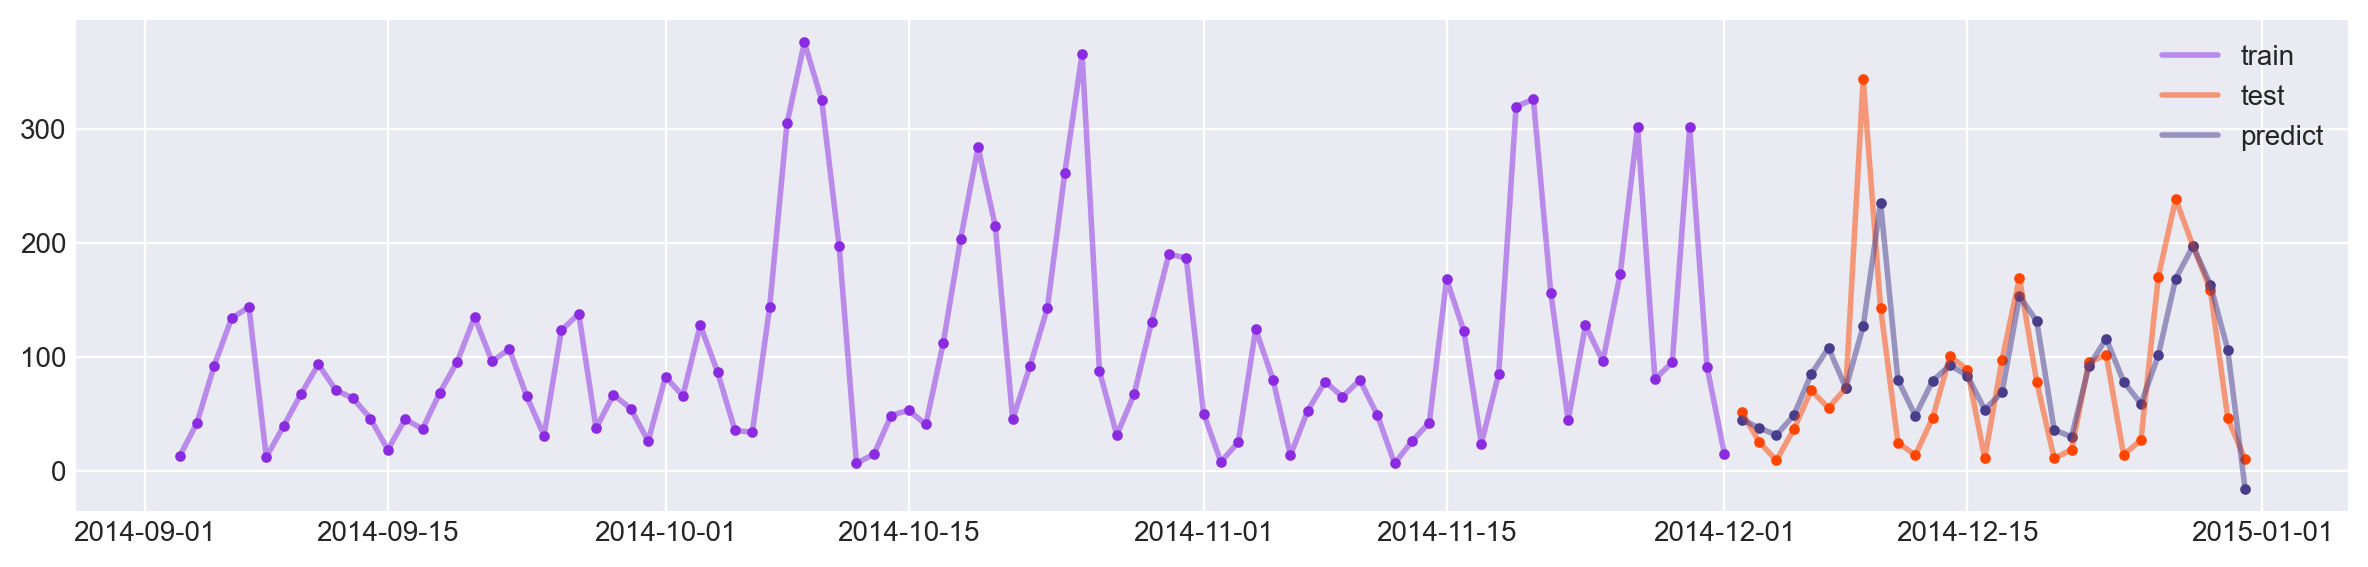

In [44]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# Best Params {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [2],
    "min_samples_split": [7],
    "n_estimators": [500],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())


gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.432 total time=  10.0s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.513 total time=  21.6s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.652 total time=  33.5s
0.5323902503370296 {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}


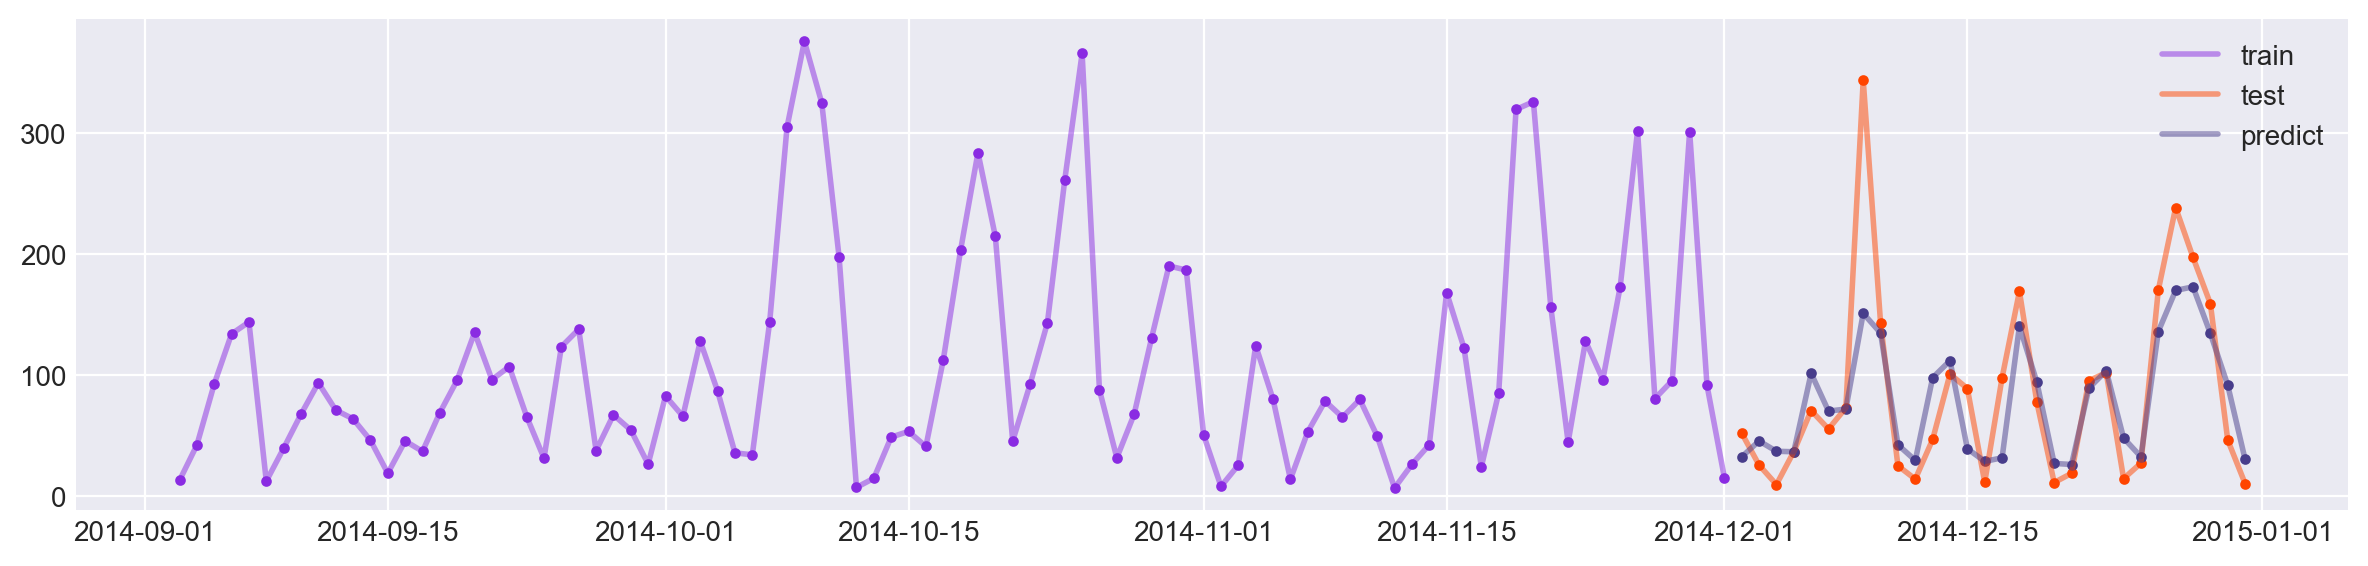

{'KNeighborsRegressor': {'mae': 55.54490740740741, 'rmse': 72.31146960033105, 'mape': 2.0304819219241006, 'r2': 0.14060948018817976}, 'BayesianRidge': {'mae': 37.82580443165425, 'rmse': 54.59979563674633, 'mape': 1.1355902393753752, 'r2': 0.510042717574813}, 'LassoCV': {'mae': 36.21162031832547, 'rmse': 55.00865935277507, 'mape': 0.9910291275834979, 'r2': 0.5026772756357456}, 'RandomForestRegressor': {'mae': 29.212996924392566, 'rmse': 45.72122346456664, 'mape': 0.6655798967902611, 'r2': 0.6564326624935637}}


In [47]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)
print(resultsDict)

### XGB Regressor

[0]	validation_0-mae:97.54016	validation_1-mae:83.00614
[1]	validation_0-mae:96.58876	validation_1-mae:82.28028
[2]	validation_0-mae:95.64673	validation_1-mae:81.53666
[3]	validation_0-mae:94.71376	validation_1-mae:80.83726
[4]	validation_0-mae:93.79151	validation_1-mae:80.15661
[5]	validation_0-mae:92.87793	validation_1-mae:79.46477
[6]	validation_0-mae:91.97360	validation_1-mae:78.80880
[7]	validation_0-mae:91.07947	validation_1-mae:78.12456
[8]	validation_0-mae:90.19446	validation_1-mae:77.45353
[9]	validation_0-mae:89.31739	validation_1-mae:76.79018
[10]	validation_0-mae:88.44921	validation_1-mae:76.15098
[11]	validation_0-mae:87.59013	validation_1-mae:75.51468
[12]	validation_0-mae:86.74069	validation_1-mae:74.88098
[13]	validation_0-mae:85.90037	validation_1-mae:74.27280
[14]	validation_0-mae:85.06833	validation_1-mae:73.60884
[15]	validation_0-mae:84.24665	validation_1-mae:72.98773
[16]	validation_0-mae:83.43340	validation_1-mae:72.39645
[17]	validation_0-mae:82.63044	validation

[144]	validation_0-mae:31.50531	validation_1-mae:36.47083
[145]	validation_0-mae:31.35306	validation_1-mae:36.37512
[146]	validation_0-mae:31.18226	validation_1-mae:36.26090
[147]	validation_0-mae:31.01964	validation_1-mae:36.12286
[148]	validation_0-mae:30.85667	validation_1-mae:36.04655
[149]	validation_0-mae:30.71042	validation_1-mae:35.93082
[150]	validation_0-mae:30.55635	validation_1-mae:35.77490
[151]	validation_0-mae:30.40144	validation_1-mae:35.69402
[152]	validation_0-mae:30.26273	validation_1-mae:35.58651
[153]	validation_0-mae:30.10648	validation_1-mae:35.44729
[154]	validation_0-mae:29.95051	validation_1-mae:35.35165
[155]	validation_0-mae:29.81562	validation_1-mae:35.25633
[156]	validation_0-mae:29.68166	validation_1-mae:35.16547
[157]	validation_0-mae:29.54095	validation_1-mae:35.06808
[158]	validation_0-mae:29.41043	validation_1-mae:35.01997
[159]	validation_0-mae:29.26256	validation_1-mae:34.94147
[160]	validation_0-mae:29.11515	validation_1-mae:34.84971
[161]	validati

[286]	validation_0-mae:19.47888	validation_1-mae:29.89852
[287]	validation_0-mae:19.42205	validation_1-mae:29.81318
[288]	validation_0-mae:19.39186	validation_1-mae:29.78846
[289]	validation_0-mae:19.34746	validation_1-mae:29.72095
[290]	validation_0-mae:19.31761	validation_1-mae:29.69655
[291]	validation_0-mae:19.27731	validation_1-mae:29.69215
[292]	validation_0-mae:19.22991	validation_1-mae:29.66804
[293]	validation_0-mae:19.17557	validation_1-mae:29.58138
[294]	validation_0-mae:19.13974	validation_1-mae:29.55611
[295]	validation_0-mae:19.09691	validation_1-mae:29.51403
[296]	validation_0-mae:19.05347	validation_1-mae:29.48602
[297]	validation_0-mae:19.01544	validation_1-mae:29.46287
[298]	validation_0-mae:18.96670	validation_1-mae:29.39910
[299]	validation_0-mae:18.91680	validation_1-mae:29.37013
[300]	validation_0-mae:18.87165	validation_1-mae:29.33853
[301]	validation_0-mae:18.82004	validation_1-mae:29.31761
[302]	validation_0-mae:18.77200	validation_1-mae:29.31269
[303]	validati

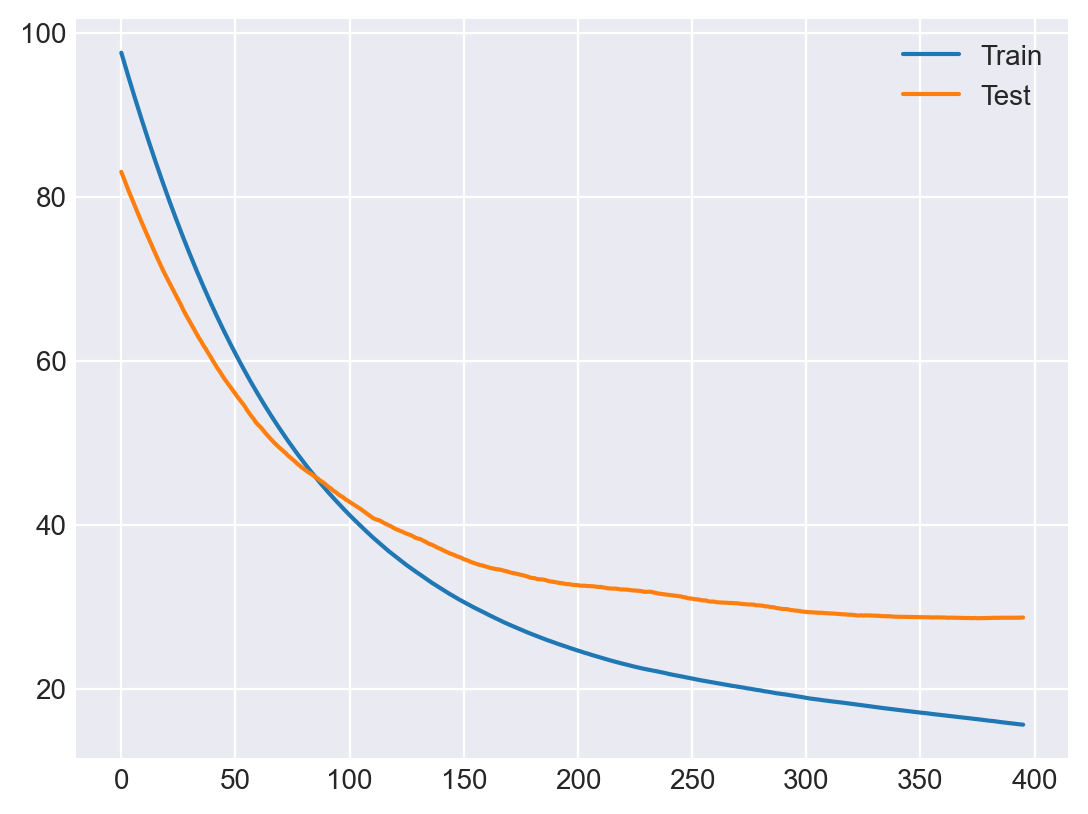

In [57]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

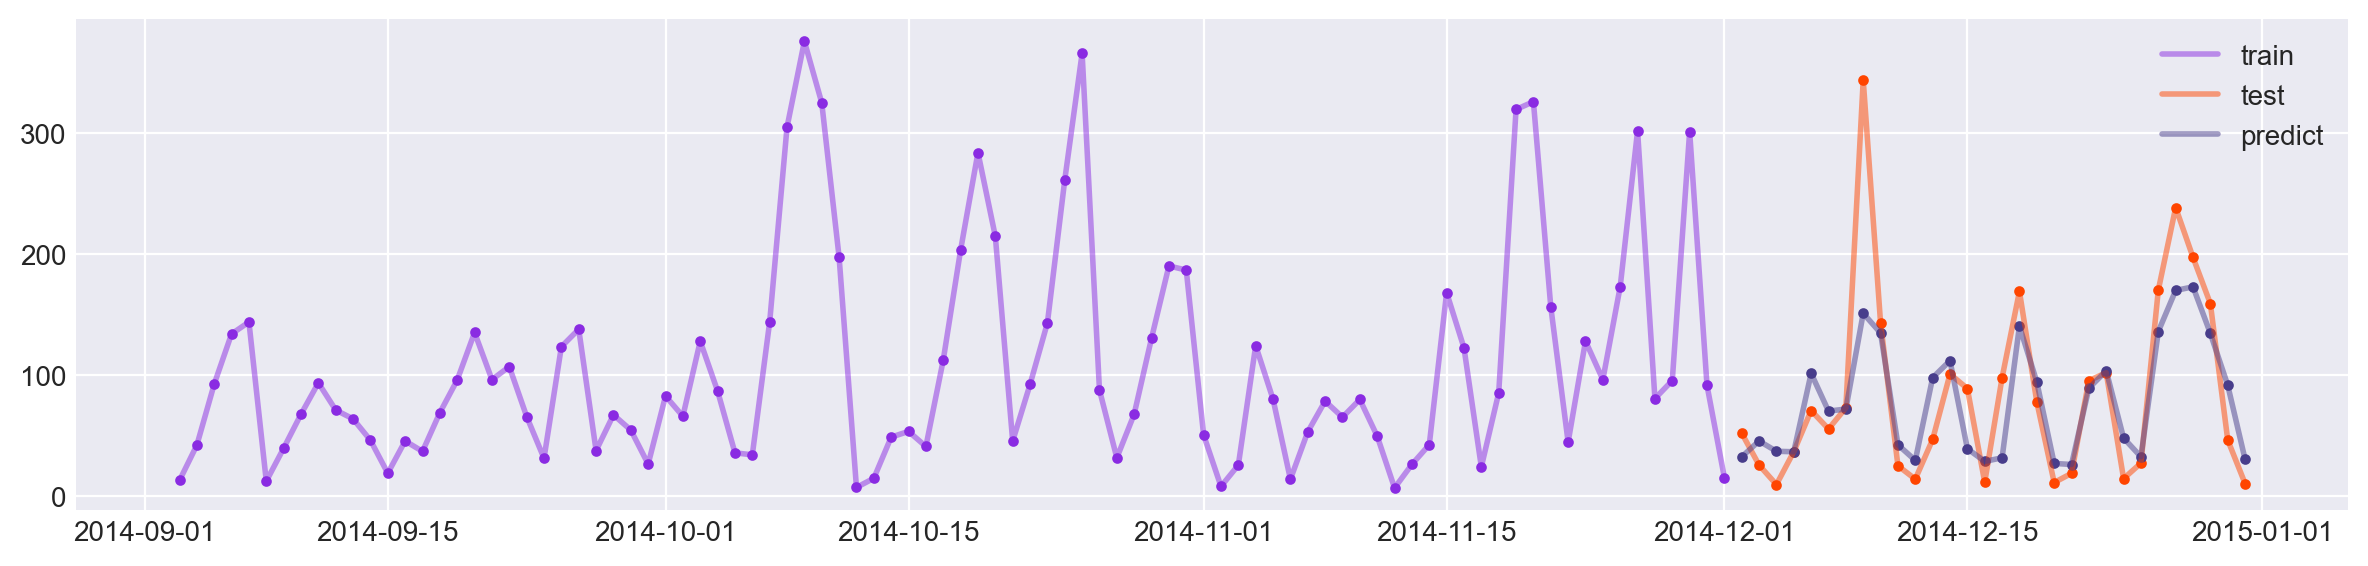

In [46]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [59]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 54.6578	training's l2: 5256.8	valid_1's l1: 59.7616	valid_1's l2: 5672.83
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 51.5635	training's l2: 4649.41	valid_1's l1: 56.6085	valid_1's l2: 5127.54
[3]	training's l1: 48.7145	training's l2: 4114.51	valid_1's l1: 54.6601	valid_1's l2: 4703.71
[4]	training's l1: 46.1541	training's l2: 3668.19	valid_1's l1: 52.264	valid_1's l2: 4359.96
[5]	training's l1: 43.9673	training's l2: 3307.41	valid_1's l1: 49.7605	valid_1's l2: 4040.69
[6]	training's l1: 41.9558	training's l2: 2995.23	valid_1's l1: 47.408	valid_1's l2: 3708.96
[7]	training's l1: 40.078	training's l2: 2723.63	valid_1's l1: 45.3174	valid_1's l2: 3451.72
[8]	training's l1: 38.4856	training's l2: 2498.66	valid_1's l1: 43.7906	valid_1's l2: 3257.81
[9]	training's l1: 37.0103	training's l2: 2306.19	valid_1's l1: 42.2098	valid_1's l2: 3068.34
[10]	training's l1: 35.6193	training's l2: 2135.54	valid_1's l1: 40.9014	valid_1's l2: 2908.64


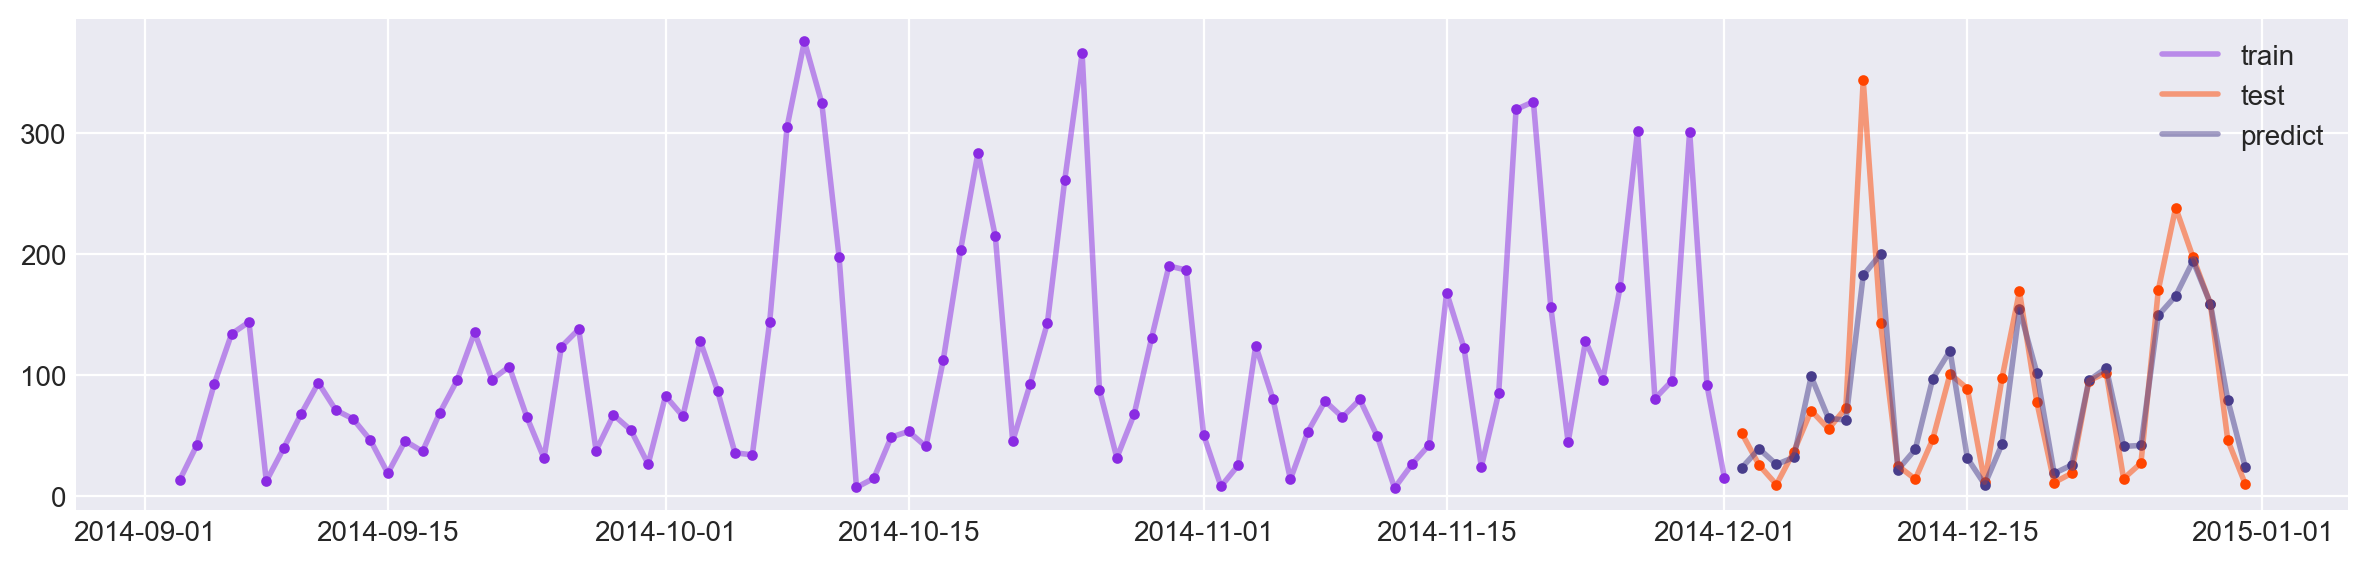

In [60]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [61]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 117.3801336	test: 120.2150105	best: 120.2150105 (0)	total: 150ms	remaining: 2m 30s
1:	learn: 109.7429898	test: 112.6886031	best: 112.6886031 (1)	total: 153ms	remaining: 1m 16s
2:	learn: 103.1416647	test: 106.7017781	best: 106.7017781 (2)	total: 156ms	remaining: 51.7s
3:	learn: 97.4444515	test: 100.6641836	best: 100.6641836 (3)	total: 158ms	remaining: 39.4s
4:	learn: 91.6620445	test: 95.0932650	best: 95.0932650 (4)	total: 160ms	remaining: 31.9s
5:	learn: 86.6388968	test: 90.0682462	best: 90.0682462 (5)	total: 162ms	remaining: 26.9s
6:	learn: 82.6124984	test: 86.2936729	best: 86.2936729 (6)	total: 165ms	remaining: 23.4s
7:	learn: 78.7341219	test: 82.6025101	best: 82.6025101 (7)	total: 170ms	remaining: 21.1s
8:	learn: 75.1180113	test: 78.6193214	best: 78.6193214 (8)	total: 188ms	remaining: 20.7s
9:	learn: 71.8544620	test: 75.1276503	best: 75.1276503 (9)	total: 204ms	remaining: 20.2s
10:	learn: 69.6149610	test: 73.1144129	best: 73.1144129 (10)	total: 216ms	remaining: 19.4s
11:	le

135:	learn: 33.4116471	test: 42.9392497	best: 42.9392497 (135)	total: 783ms	remaining: 4.97s
136:	learn: 33.2899779	test: 42.9133184	best: 42.9133184 (136)	total: 785ms	remaining: 4.95s
137:	learn: 33.1759013	test: 42.8421403	best: 42.8421403 (137)	total: 788ms	remaining: 4.92s
138:	learn: 33.0934553	test: 42.8517041	best: 42.8421403 (137)	total: 790ms	remaining: 4.89s
139:	learn: 32.9689325	test: 42.7649093	best: 42.7649093 (139)	total: 792ms	remaining: 4.86s
140:	learn: 32.9033838	test: 42.7625009	best: 42.7625009 (140)	total: 794ms	remaining: 4.84s
141:	learn: 32.8517048	test: 42.7618491	best: 42.7618491 (141)	total: 797ms	remaining: 4.81s
142:	learn: 32.7493116	test: 42.6513362	best: 42.6513362 (142)	total: 799ms	remaining: 4.79s
143:	learn: 32.6652244	test: 42.6389267	best: 42.6389267 (143)	total: 801ms	remaining: 4.76s
144:	learn: 32.5912525	test: 42.6299216	best: 42.6299216 (144)	total: 804ms	remaining: 4.74s
145:	learn: 32.4864935	test: 42.6240684	best: 42.6240684 (145)	total: 

233:	learn: 26.5054789	test: 40.7659929	best: 40.7657656 (232)	total: 1.19s	remaining: 3.89s
234:	learn: 26.4445642	test: 40.7562042	best: 40.7562042 (234)	total: 1.19s	remaining: 3.87s
235:	learn: 26.3734910	test: 40.7730027	best: 40.7562042 (234)	total: 1.19s	remaining: 3.86s
236:	learn: 26.3388909	test: 40.7696299	best: 40.7562042 (234)	total: 1.19s	remaining: 3.85s
237:	learn: 26.2627302	test: 40.7469902	best: 40.7469902 (237)	total: 1.2s	remaining: 3.83s
238:	learn: 26.2226353	test: 40.7413374	best: 40.7413374 (238)	total: 1.2s	remaining: 3.82s
239:	learn: 26.1732464	test: 40.7273805	best: 40.7273805 (239)	total: 1.2s	remaining: 3.81s
240:	learn: 26.0980945	test: 40.7413500	best: 40.7273805 (239)	total: 1.21s	remaining: 3.8s
241:	learn: 26.0244233	test: 40.6999340	best: 40.6999340 (241)	total: 1.21s	remaining: 3.79s
242:	learn: 25.9346004	test: 40.6182042	best: 40.6182042 (242)	total: 1.22s	remaining: 3.79s
243:	learn: 25.8552016	test: 40.5904949	best: 40.5904949 (243)	total: 1.22

331:	learn: 21.7392367	test: 39.7574371	best: 39.7546836 (329)	total: 1.61s	remaining: 3.23s
332:	learn: 21.6975598	test: 39.7402055	best: 39.7402055 (332)	total: 1.61s	remaining: 3.22s
333:	learn: 21.6716935	test: 39.7317635	best: 39.7317635 (333)	total: 1.61s	remaining: 3.21s
334:	learn: 21.6382704	test: 39.7400293	best: 39.7317635 (333)	total: 1.61s	remaining: 3.2s
335:	learn: 21.6174069	test: 39.7213379	best: 39.7213379 (335)	total: 1.61s	remaining: 3.19s
336:	learn: 21.5852600	test: 39.7177621	best: 39.7177621 (336)	total: 1.62s	remaining: 3.18s
337:	learn: 21.5433477	test: 39.7222049	best: 39.7177621 (336)	total: 1.62s	remaining: 3.17s
338:	learn: 21.4854740	test: 39.7645478	best: 39.7177621 (336)	total: 1.62s	remaining: 3.16s
339:	learn: 21.4470186	test: 39.7484518	best: 39.7177621 (336)	total: 1.63s	remaining: 3.15s
340:	learn: 21.4142880	test: 39.7427821	best: 39.7177621 (336)	total: 1.63s	remaining: 3.15s
341:	learn: 21.3695019	test: 39.7396551	best: 39.7177621 (336)	total: 1

429:	learn: 18.1430030	test: 39.6331010	best: 39.5884728 (424)	total: 2.01s	remaining: 2.67s
430:	learn: 18.1120159	test: 39.6280680	best: 39.5884728 (424)	total: 2.01s	remaining: 2.66s
431:	learn: 18.0810540	test: 39.6318930	best: 39.5884728 (424)	total: 2.02s	remaining: 2.65s
432:	learn: 18.0328116	test: 39.6442582	best: 39.5884728 (424)	total: 2.02s	remaining: 2.64s
433:	learn: 18.0003378	test: 39.6331794	best: 39.5884728 (424)	total: 2.02s	remaining: 2.63s
434:	learn: 17.9586893	test: 39.6057274	best: 39.5884728 (424)	total: 2.02s	remaining: 2.63s
435:	learn: 17.9393550	test: 39.6100632	best: 39.5884728 (424)	total: 2.02s	remaining: 2.62s
436:	learn: 17.9061756	test: 39.6111166	best: 39.5884728 (424)	total: 2.03s	remaining: 2.61s
437:	learn: 17.8836318	test: 39.6142242	best: 39.5884728 (424)	total: 2.03s	remaining: 2.6s
438:	learn: 17.8352990	test: 39.6464505	best: 39.5884728 (424)	total: 2.03s	remaining: 2.6s
439:	learn: 17.8042952	test: 39.6413748	best: 39.5884728 (424)	total: 2.

537:	learn: 15.2144908	test: 39.2940161	best: 39.2925203 (534)	total: 2.42s	remaining: 2.08s
538:	learn: 15.1783671	test: 39.2482288	best: 39.2482288 (538)	total: 2.42s	remaining: 2.07s
539:	learn: 15.1591807	test: 39.2643452	best: 39.2482288 (538)	total: 2.43s	remaining: 2.07s
540:	learn: 15.1291383	test: 39.2842249	best: 39.2482288 (538)	total: 2.43s	remaining: 2.06s
541:	learn: 15.0860373	test: 39.2796954	best: 39.2482288 (538)	total: 2.43s	remaining: 2.05s
542:	learn: 15.0644593	test: 39.2946908	best: 39.2482288 (538)	total: 2.44s	remaining: 2.05s
543:	learn: 15.0373802	test: 39.3139967	best: 39.2482288 (538)	total: 2.44s	remaining: 2.05s
544:	learn: 15.0361086	test: 39.3137768	best: 39.2482288 (538)	total: 2.44s	remaining: 2.04s
545:	learn: 15.0038932	test: 39.3178210	best: 39.2482288 (538)	total: 2.45s	remaining: 2.04s
546:	learn: 14.9945426	test: 39.3173343	best: 39.2482288 (538)	total: 2.46s	remaining: 2.03s
547:	learn: 14.9586982	test: 39.3208349	best: 39.2482288 (538)	total: 

636:	learn: 12.7797501	test: 39.0288247	best: 38.9791017 (622)	total: 2.83s	remaining: 1.61s
637:	learn: 12.7670579	test: 39.0176609	best: 38.9791017 (622)	total: 2.83s	remaining: 1.61s
638:	learn: 12.7493244	test: 39.0012490	best: 38.9791017 (622)	total: 2.83s	remaining: 1.6s
639:	learn: 12.7208699	test: 39.0024371	best: 38.9791017 (622)	total: 2.84s	remaining: 1.6s
640:	learn: 12.6994375	test: 38.9933986	best: 38.9791017 (622)	total: 2.84s	remaining: 1.59s
641:	learn: 12.6865641	test: 38.9938907	best: 38.9791017 (622)	total: 2.85s	remaining: 1.59s
642:	learn: 12.6756990	test: 38.9947585	best: 38.9791017 (622)	total: 2.85s	remaining: 1.58s
643:	learn: 12.6453029	test: 39.0052629	best: 38.9791017 (622)	total: 2.85s	remaining: 1.58s
644:	learn: 12.6264012	test: 39.0003281	best: 38.9791017 (622)	total: 2.86s	remaining: 1.57s
645:	learn: 12.6046019	test: 38.9936540	best: 38.9791017 (622)	total: 2.86s	remaining: 1.57s
646:	learn: 12.5861213	test: 38.9994326	best: 38.9791017 (622)	total: 2.

732:	learn: 10.8622058	test: 38.9038576	best: 38.8847758 (726)	total: 3.24s	remaining: 1.18s
733:	learn: 10.8460291	test: 38.9016010	best: 38.8847758 (726)	total: 3.24s	remaining: 1.17s
734:	learn: 10.8200191	test: 38.8988211	best: 38.8847758 (726)	total: 3.24s	remaining: 1.17s
735:	learn: 10.8010962	test: 38.9066145	best: 38.8847758 (726)	total: 3.25s	remaining: 1.16s
736:	learn: 10.7849080	test: 38.9056346	best: 38.8847758 (726)	total: 3.25s	remaining: 1.16s
737:	learn: 10.7580084	test: 38.9089377	best: 38.8847758 (726)	total: 3.25s	remaining: 1.15s
738:	learn: 10.7378039	test: 38.9147282	best: 38.8847758 (726)	total: 3.25s	remaining: 1.15s
739:	learn: 10.7197209	test: 38.9191335	best: 38.8847758 (726)	total: 3.26s	remaining: 1.14s
740:	learn: 10.7088211	test: 38.9110945	best: 38.8847758 (726)	total: 3.26s	remaining: 1.14s
741:	learn: 10.6860649	test: 38.9179588	best: 38.8847758 (726)	total: 3.26s	remaining: 1.13s
742:	learn: 10.6608003	test: 38.9152264	best: 38.8847758 (726)	total: 

829:	learn: 9.3737587	test: 38.8848669	best: 38.8397349 (756)	total: 3.65s	remaining: 747ms
830:	learn: 9.3590560	test: 38.8831414	best: 38.8397349 (756)	total: 3.65s	remaining: 742ms
831:	learn: 9.3455599	test: 38.8922062	best: 38.8397349 (756)	total: 3.65s	remaining: 737ms
832:	learn: 9.3263085	test: 38.8996911	best: 38.8397349 (756)	total: 3.65s	remaining: 733ms
833:	learn: 9.3088533	test: 38.9020588	best: 38.8397349 (756)	total: 3.66s	remaining: 728ms
834:	learn: 9.2913738	test: 38.9036122	best: 38.8397349 (756)	total: 3.66s	remaining: 723ms
835:	learn: 9.2830500	test: 38.9043228	best: 38.8397349 (756)	total: 3.66s	remaining: 718ms
836:	learn: 9.2675497	test: 38.8979585	best: 38.8397349 (756)	total: 3.66s	remaining: 714ms
837:	learn: 9.2556248	test: 38.8729553	best: 38.8397349 (756)	total: 3.67s	remaining: 709ms
838:	learn: 9.2304309	test: 38.8724239	best: 38.8397349 (756)	total: 3.67s	remaining: 704ms
839:	learn: 9.2141010	test: 38.8707293	best: 38.8397349 (756)	total: 3.67s	remai

928:	learn: 8.0801662	test: 38.8422733	best: 38.7784278 (879)	total: 4.05s	remaining: 309ms
929:	learn: 8.0742828	test: 38.8418791	best: 38.7784278 (879)	total: 4.05s	remaining: 305ms
930:	learn: 8.0670758	test: 38.8591602	best: 38.7784278 (879)	total: 4.05s	remaining: 300ms
931:	learn: 8.0606622	test: 38.8551147	best: 38.7784278 (879)	total: 4.05s	remaining: 296ms
932:	learn: 8.0444390	test: 38.8553229	best: 38.7784278 (879)	total: 4.06s	remaining: 291ms
933:	learn: 8.0232976	test: 38.8559989	best: 38.7784278 (879)	total: 4.06s	remaining: 287ms
934:	learn: 8.0199452	test: 38.8561676	best: 38.7784278 (879)	total: 4.06s	remaining: 282ms
935:	learn: 8.0069618	test: 38.8556125	best: 38.7784278 (879)	total: 4.07s	remaining: 278ms
936:	learn: 7.9867514	test: 38.8548922	best: 38.7784278 (879)	total: 4.07s	remaining: 274ms
937:	learn: 7.9705910	test: 38.8499335	best: 38.7784278 (879)	total: 4.07s	remaining: 269ms
938:	learn: 7.9607468	test: 38.8386362	best: 38.7784278 (879)	total: 4.07s	remai

30:	learn: 50.2022556	test: 52.9853175	best: 52.9853175 (30)	total: 108ms	remaining: 3.37s
31:	learn: 49.9220085	test: 52.7088591	best: 52.7088591 (31)	total: 110ms	remaining: 3.33s
32:	learn: 49.6239168	test: 52.5071629	best: 52.5071629 (32)	total: 113ms	remaining: 3.3s
33:	learn: 49.2660368	test: 52.0908635	best: 52.0908635 (33)	total: 115ms	remaining: 3.27s
34:	learn: 48.9274415	test: 51.7510190	best: 51.7510190 (34)	total: 117ms	remaining: 3.23s
35:	learn: 48.6003787	test: 51.4200795	best: 51.4200795 (35)	total: 120ms	remaining: 3.21s
36:	learn: 48.1895583	test: 51.0941486	best: 51.0941486 (36)	total: 122ms	remaining: 3.18s
37:	learn: 48.0907411	test: 51.0933601	best: 51.0933601 (37)	total: 125ms	remaining: 3.17s
38:	learn: 47.8377473	test: 50.9148738	best: 50.9148738 (38)	total: 130ms	remaining: 3.2s
39:	learn: 47.6293618	test: 50.7463314	best: 50.7463314 (39)	total: 134ms	remaining: 3.23s
40:	learn: 47.3360242	test: 50.4808306	best: 50.4808306 (40)	total: 139ms	remaining: 3.25s
4

126:	learn: 34.9520904	test: 42.9731428	best: 42.9731428 (126)	total: 519ms	remaining: 3.57s
127:	learn: 34.8458648	test: 42.8785850	best: 42.8785850 (127)	total: 522ms	remaining: 3.55s
128:	learn: 34.7687260	test: 42.8468867	best: 42.8468867 (128)	total: 524ms	remaining: 3.54s
129:	learn: 34.6793833	test: 42.8107095	best: 42.8107095 (129)	total: 526ms	remaining: 3.52s
130:	learn: 34.5914733	test: 42.7592606	best: 42.7592606 (130)	total: 529ms	remaining: 3.51s
131:	learn: 34.5498856	test: 42.7510031	best: 42.7510031 (131)	total: 531ms	remaining: 3.49s
132:	learn: 34.4502697	test: 42.6859844	best: 42.6859844 (132)	total: 534ms	remaining: 3.48s
133:	learn: 34.3309613	test: 42.5497221	best: 42.5497221 (133)	total: 536ms	remaining: 3.46s
134:	learn: 34.2598261	test: 42.5043589	best: 42.5043589 (134)	total: 538ms	remaining: 3.45s
135:	learn: 34.1572001	test: 42.4105298	best: 42.4105298 (135)	total: 541ms	remaining: 3.44s
136:	learn: 34.0927316	test: 42.4100547	best: 42.4100547 (136)	total: 

228:	learn: 27.8023924	test: 40.5763844	best: 40.5330880 (224)	total: 923ms	remaining: 3.11s
229:	learn: 27.7310188	test: 40.5580781	best: 40.5330880 (224)	total: 926ms	remaining: 3.1s
230:	learn: 27.6862649	test: 40.5657725	best: 40.5330880 (224)	total: 928ms	remaining: 3.09s
231:	learn: 27.6125509	test: 40.5381860	best: 40.5330880 (224)	total: 930ms	remaining: 3.08s
232:	learn: 27.5308789	test: 40.5601469	best: 40.5330880 (224)	total: 932ms	remaining: 3.07s
233:	learn: 27.4950115	test: 40.5422262	best: 40.5330880 (224)	total: 937ms	remaining: 3.07s
234:	learn: 27.4188463	test: 40.4836333	best: 40.4836333 (234)	total: 942ms	remaining: 3.07s
235:	learn: 27.3547849	test: 40.4912026	best: 40.4836333 (234)	total: 947ms	remaining: 3.07s
236:	learn: 27.2809325	test: 40.5045619	best: 40.4836333 (234)	total: 952ms	remaining: 3.06s
237:	learn: 27.2321570	test: 40.4876167	best: 40.4836333 (234)	total: 957ms	remaining: 3.06s
238:	learn: 27.1801306	test: 40.4873253	best: 40.4836333 (234)	total: 9

330:	learn: 23.0210444	test: 39.7949053	best: 39.7914445 (329)	total: 1.33s	remaining: 2.68s
331:	learn: 22.9818815	test: 39.7755476	best: 39.7755476 (331)	total: 1.33s	remaining: 2.68s
332:	learn: 22.9595595	test: 39.7747115	best: 39.7747115 (332)	total: 1.33s	remaining: 2.67s
333:	learn: 22.9129825	test: 39.7479211	best: 39.7479211 (333)	total: 1.33s	remaining: 2.66s
334:	learn: 22.8463172	test: 39.7676714	best: 39.7479211 (333)	total: 1.34s	remaining: 2.65s
335:	learn: 22.7851891	test: 39.7751347	best: 39.7479211 (333)	total: 1.34s	remaining: 2.65s
336:	learn: 22.7439693	test: 39.7908690	best: 39.7479211 (333)	total: 1.34s	remaining: 2.64s
337:	learn: 22.6770280	test: 39.7381459	best: 39.7381459 (337)	total: 1.34s	remaining: 2.63s
338:	learn: 22.6252575	test: 39.8072856	best: 39.7381459 (337)	total: 1.35s	remaining: 2.63s
339:	learn: 22.5783438	test: 39.7808277	best: 39.7381459 (337)	total: 1.35s	remaining: 2.62s
340:	learn: 22.5125819	test: 39.8150815	best: 39.7381459 (337)	total: 

431:	learn: 19.4288172	test: 39.4296054	best: 39.3154362 (392)	total: 1.74s	remaining: 2.29s
432:	learn: 19.4001515	test: 39.4130786	best: 39.3154362 (392)	total: 1.74s	remaining: 2.28s
433:	learn: 19.3779191	test: 39.4071394	best: 39.3154362 (392)	total: 1.75s	remaining: 2.28s
434:	learn: 19.3329720	test: 39.3924299	best: 39.3154362 (392)	total: 1.75s	remaining: 2.27s
435:	learn: 19.2901428	test: 39.3874896	best: 39.3154362 (392)	total: 1.75s	remaining: 2.27s
436:	learn: 19.2536029	test: 39.3815115	best: 39.3154362 (392)	total: 1.76s	remaining: 2.27s
437:	learn: 19.2291616	test: 39.3842076	best: 39.3154362 (392)	total: 1.76s	remaining: 2.26s
438:	learn: 19.1972032	test: 39.3810678	best: 39.3154362 (392)	total: 1.77s	remaining: 2.26s
439:	learn: 19.1754961	test: 39.3854614	best: 39.3154362 (392)	total: 1.77s	remaining: 2.25s
440:	learn: 19.1486288	test: 39.3879252	best: 39.3154362 (392)	total: 1.78s	remaining: 2.25s
441:	learn: 19.1188997	test: 39.3787042	best: 39.3154362 (392)	total: 

527:	learn: 16.6147587	test: 39.3268234	best: 39.2748527 (510)	total: 2.15s	remaining: 1.92s
528:	learn: 16.5946008	test: 39.3341426	best: 39.2748527 (510)	total: 2.15s	remaining: 1.92s
529:	learn: 16.5572824	test: 39.3456150	best: 39.2748527 (510)	total: 2.15s	remaining: 1.91s
530:	learn: 16.5512291	test: 39.3421965	best: 39.2748527 (510)	total: 2.16s	remaining: 1.91s
531:	learn: 16.5476212	test: 39.3435351	best: 39.2748527 (510)	total: 2.16s	remaining: 1.9s
532:	learn: 16.5261471	test: 39.3389023	best: 39.2748527 (510)	total: 2.16s	remaining: 1.89s
533:	learn: 16.5034296	test: 39.3189016	best: 39.2748527 (510)	total: 2.17s	remaining: 1.89s
534:	learn: 16.4799082	test: 39.3071423	best: 39.2748527 (510)	total: 2.17s	remaining: 1.88s
535:	learn: 16.4612443	test: 39.3097831	best: 39.2748527 (510)	total: 2.17s	remaining: 1.88s
536:	learn: 16.4542574	test: 39.3098150	best: 39.2748527 (510)	total: 2.17s	remaining: 1.87s
537:	learn: 16.4191153	test: 39.3383403	best: 39.2748527 (510)	total: 2

631:	learn: 14.1503040	test: 39.4009781	best: 39.2361249 (586)	total: 2.55s	remaining: 1.49s
632:	learn: 14.1193653	test: 39.4014150	best: 39.2361249 (586)	total: 2.56s	remaining: 1.48s
633:	learn: 14.0914865	test: 39.4009684	best: 39.2361249 (586)	total: 2.56s	remaining: 1.48s
634:	learn: 14.0605775	test: 39.3955972	best: 39.2361249 (586)	total: 2.56s	remaining: 1.47s
635:	learn: 14.0348609	test: 39.3903661	best: 39.2361249 (586)	total: 2.56s	remaining: 1.47s
636:	learn: 14.0010116	test: 39.3877416	best: 39.2361249 (586)	total: 2.56s	remaining: 1.46s
637:	learn: 13.9781604	test: 39.4065336	best: 39.2361249 (586)	total: 2.57s	remaining: 1.46s
638:	learn: 13.9409183	test: 39.4132761	best: 39.2361249 (586)	total: 2.57s	remaining: 1.45s
639:	learn: 13.9252885	test: 39.4156440	best: 39.2361249 (586)	total: 2.57s	remaining: 1.45s
640:	learn: 13.9002996	test: 39.4272473	best: 39.2361249 (586)	total: 2.57s	remaining: 1.44s
641:	learn: 13.8863641	test: 39.4247691	best: 39.2361249 (586)	total: 

728:	learn: 12.1883188	test: 39.4251403	best: 39.2361249 (586)	total: 2.96s	remaining: 1.1s
729:	learn: 12.1827842	test: 39.4260641	best: 39.2361249 (586)	total: 2.96s	remaining: 1.09s
730:	learn: 12.1638780	test: 39.4226606	best: 39.2361249 (586)	total: 2.96s	remaining: 1.09s
731:	learn: 12.1459390	test: 39.4079964	best: 39.2361249 (586)	total: 2.96s	remaining: 1.08s
732:	learn: 12.1130170	test: 39.4100075	best: 39.2361249 (586)	total: 2.97s	remaining: 1.08s
733:	learn: 12.0883125	test: 39.4302162	best: 39.2361249 (586)	total: 2.97s	remaining: 1.08s
734:	learn: 12.0739565	test: 39.4314310	best: 39.2361249 (586)	total: 2.98s	remaining: 1.07s
735:	learn: 12.0634758	test: 39.4213247	best: 39.2361249 (586)	total: 2.98s	remaining: 1.07s
736:	learn: 12.0402184	test: 39.4423115	best: 39.2361249 (586)	total: 2.99s	remaining: 1.06s
737:	learn: 12.0181887	test: 39.4378461	best: 39.2361249 (586)	total: 2.99s	remaining: 1.06s
738:	learn: 11.9927511	test: 39.4374853	best: 39.2361249 (586)	total: 3

831:	learn: 10.6113836	test: 39.4803164	best: 39.2361249 (586)	total: 3.37s	remaining: 680ms
832:	learn: 10.5998341	test: 39.4818520	best: 39.2361249 (586)	total: 3.37s	remaining: 675ms
833:	learn: 10.5989878	test: 39.4827186	best: 39.2361249 (586)	total: 3.37s	remaining: 671ms
834:	learn: 10.5925544	test: 39.4781873	best: 39.2361249 (586)	total: 3.37s	remaining: 667ms
835:	learn: 10.5743545	test: 39.4914873	best: 39.2361249 (586)	total: 3.38s	remaining: 662ms
836:	learn: 10.5622264	test: 39.4924695	best: 39.2361249 (586)	total: 3.38s	remaining: 658ms
837:	learn: 10.5478168	test: 39.4825148	best: 39.2361249 (586)	total: 3.38s	remaining: 654ms
838:	learn: 10.5370180	test: 39.4839754	best: 39.2361249 (586)	total: 3.38s	remaining: 649ms
839:	learn: 10.5203333	test: 39.4874905	best: 39.2361249 (586)	total: 3.38s	remaining: 645ms
840:	learn: 10.5070533	test: 39.4940495	best: 39.2361249 (586)	total: 3.39s	remaining: 640ms
841:	learn: 10.5060978	test: 39.4934441	best: 39.2361249 (586)	total: 

936:	learn: 9.3305778	test: 39.4244511	best: 39.2361249 (586)	total: 3.77s	remaining: 254ms
937:	learn: 9.3190095	test: 39.4243017	best: 39.2361249 (586)	total: 3.78s	remaining: 250ms
938:	learn: 9.3089448	test: 39.4298594	best: 39.2361249 (586)	total: 3.78s	remaining: 246ms
939:	learn: 9.2924477	test: 39.4383426	best: 39.2361249 (586)	total: 3.78s	remaining: 241ms
940:	learn: 9.2857994	test: 39.4470275	best: 39.2361249 (586)	total: 3.78s	remaining: 237ms
941:	learn: 9.2850059	test: 39.4467917	best: 39.2361249 (586)	total: 3.79s	remaining: 233ms
942:	learn: 9.2766101	test: 39.4443719	best: 39.2361249 (586)	total: 3.79s	remaining: 229ms
943:	learn: 9.2760767	test: 39.4445441	best: 39.2361249 (586)	total: 3.79s	remaining: 225ms
944:	learn: 9.2575248	test: 39.4483233	best: 39.2361249 (586)	total: 3.79s	remaining: 221ms
945:	learn: 9.2470102	test: 39.4473976	best: 39.2361249 (586)	total: 3.8s	remaining: 217ms
946:	learn: 9.2358597	test: 39.4433820	best: 39.2361249 (586)	total: 3.8s	remaini

67:	learn: 40.6128084	test: 48.0302192	best: 48.0302192 (67)	total: 343ms	remaining: 4.71s
68:	learn: 40.4146408	test: 47.9777937	best: 47.9777937 (68)	total: 346ms	remaining: 4.67s
69:	learn: 40.1705861	test: 47.8228375	best: 47.8228375 (69)	total: 348ms	remaining: 4.62s
70:	learn: 40.0408698	test: 47.7771664	best: 47.7771664 (70)	total: 350ms	remaining: 4.58s
71:	learn: 39.8011430	test: 47.6466768	best: 47.6466768 (71)	total: 352ms	remaining: 4.54s
72:	learn: 39.6732486	test: 47.5886272	best: 47.5886272 (72)	total: 355ms	remaining: 4.5s
73:	learn: 39.3936261	test: 47.5083931	best: 47.5083931 (73)	total: 357ms	remaining: 4.47s
74:	learn: 39.2242733	test: 47.4398639	best: 47.4398639 (74)	total: 359ms	remaining: 4.43s
75:	learn: 39.1325623	test: 47.4723217	best: 47.4398639 (74)	total: 362ms	remaining: 4.4s
76:	learn: 38.9061057	test: 47.3732752	best: 47.3732752 (76)	total: 364ms	remaining: 4.36s
77:	learn: 38.7149130	test: 47.2614643	best: 47.2614643 (77)	total: 366ms	remaining: 4.33s
7

174:	learn: 27.3141241	test: 44.4830315	best: 44.4491817 (172)	total: 750ms	remaining: 3.53s
175:	learn: 27.2706895	test: 44.4599343	best: 44.4491817 (172)	total: 752ms	remaining: 3.52s
176:	learn: 27.2264216	test: 44.4913382	best: 44.4491817 (172)	total: 754ms	remaining: 3.51s
177:	learn: 27.1649560	test: 44.4410270	best: 44.4410270 (177)	total: 756ms	remaining: 3.49s
178:	learn: 27.0898498	test: 44.4587811	best: 44.4410270 (177)	total: 759ms	remaining: 3.48s
179:	learn: 27.0095351	test: 44.4747623	best: 44.4410270 (177)	total: 761ms	remaining: 3.47s
180:	learn: 26.9766590	test: 44.4640886	best: 44.4410270 (177)	total: 763ms	remaining: 3.45s
181:	learn: 26.9671761	test: 44.4703526	best: 44.4410270 (177)	total: 765ms	remaining: 3.44s
182:	learn: 26.9279388	test: 44.4849050	best: 44.4410270 (177)	total: 768ms	remaining: 3.43s
183:	learn: 26.8809154	test: 44.5014571	best: 44.4410270 (177)	total: 770ms	remaining: 3.41s
184:	learn: 26.7877522	test: 44.4610018	best: 44.4410270 (177)	total: 

269:	learn: 21.5273329	test: 44.8865919	best: 44.4410270 (177)	total: 1.16s	remaining: 3.13s
270:	learn: 21.4928792	test: 44.8867342	best: 44.4410270 (177)	total: 1.16s	remaining: 3.12s
271:	learn: 21.4487310	test: 44.8675636	best: 44.4410270 (177)	total: 1.16s	remaining: 3.11s
272:	learn: 21.3899222	test: 44.8737855	best: 44.4410270 (177)	total: 1.17s	remaining: 3.1s
273:	learn: 21.3356913	test: 44.8663704	best: 44.4410270 (177)	total: 1.17s	remaining: 3.1s
274:	learn: 21.2843465	test: 44.8641244	best: 44.4410270 (177)	total: 1.17s	remaining: 3.08s
275:	learn: 21.2734675	test: 44.8651347	best: 44.4410270 (177)	total: 1.17s	remaining: 3.08s
276:	learn: 21.2212237	test: 44.8741553	best: 44.4410270 (177)	total: 1.17s	remaining: 3.06s
277:	learn: 21.1562915	test: 44.8861727	best: 44.4410270 (177)	total: 1.18s	remaining: 3.06s
278:	learn: 21.1074454	test: 44.8826530	best: 44.4410270 (177)	total: 1.18s	remaining: 3.05s
279:	learn: 21.0813151	test: 44.8978063	best: 44.4410270 (177)	total: 1.

365:	learn: 17.1665217	test: 45.0082351	best: 44.4410270 (177)	total: 1.56s	remaining: 2.71s
366:	learn: 17.1447560	test: 45.0097868	best: 44.4410270 (177)	total: 1.56s	remaining: 2.7s
367:	learn: 17.1274984	test: 45.0288121	best: 44.4410270 (177)	total: 1.57s	remaining: 2.69s
368:	learn: 17.0604847	test: 45.0129311	best: 44.4410270 (177)	total: 1.57s	remaining: 2.68s
369:	learn: 16.9976781	test: 45.0156785	best: 44.4410270 (177)	total: 1.57s	remaining: 2.67s
370:	learn: 16.9878016	test: 45.0211052	best: 44.4410270 (177)	total: 1.57s	remaining: 2.67s
371:	learn: 16.9528981	test: 45.0191263	best: 44.4410270 (177)	total: 1.57s	remaining: 2.66s
372:	learn: 16.9308436	test: 45.0242035	best: 44.4410270 (177)	total: 1.58s	remaining: 2.65s
373:	learn: 16.8971111	test: 45.0154669	best: 44.4410270 (177)	total: 1.58s	remaining: 2.64s
374:	learn: 16.8500113	test: 45.0064746	best: 44.4410270 (177)	total: 1.58s	remaining: 2.64s
375:	learn: 16.8117971	test: 45.0108062	best: 44.4410270 (177)	total: 1

476:	learn: 13.6002349	test: 45.1426054	best: 44.4410270 (177)	total: 1.97s	remaining: 2.16s
477:	learn: 13.5653261	test: 45.1458486	best: 44.4410270 (177)	total: 1.97s	remaining: 2.15s
478:	learn: 13.5349065	test: 45.1520475	best: 44.4410270 (177)	total: 1.97s	remaining: 2.15s
479:	learn: 13.5121183	test: 45.1580713	best: 44.4410270 (177)	total: 1.97s	remaining: 2.14s
480:	learn: 13.4753974	test: 45.1539246	best: 44.4410270 (177)	total: 1.98s	remaining: 2.13s
481:	learn: 13.4297641	test: 45.1478013	best: 44.4410270 (177)	total: 1.98s	remaining: 2.13s
482:	learn: 13.3913069	test: 45.1654735	best: 44.4410270 (177)	total: 1.98s	remaining: 2.12s
483:	learn: 13.3889952	test: 45.1654320	best: 44.4410270 (177)	total: 1.99s	remaining: 2.12s
484:	learn: 13.3729179	test: 45.1737300	best: 44.4410270 (177)	total: 1.99s	remaining: 2.12s
485:	learn: 13.3431039	test: 45.1900787	best: 44.4410270 (177)	total: 2s	remaining: 2.11s
486:	learn: 13.3103326	test: 45.1913288	best: 44.4410270 (177)	total: 2s	

568:	learn: 11.4776998	test: 45.3163292	best: 44.4410270 (177)	total: 2.36s	remaining: 1.79s
569:	learn: 11.4516483	test: 45.3250930	best: 44.4410270 (177)	total: 2.36s	remaining: 1.78s
570:	learn: 11.4364403	test: 45.3256895	best: 44.4410270 (177)	total: 2.36s	remaining: 1.78s
571:	learn: 11.4041340	test: 45.3148263	best: 44.4410270 (177)	total: 2.37s	remaining: 1.77s
572:	learn: 11.3830146	test: 45.3137372	best: 44.4410270 (177)	total: 2.37s	remaining: 1.76s
573:	learn: 11.3610432	test: 45.3217862	best: 44.4410270 (177)	total: 2.37s	remaining: 1.76s
574:	learn: 11.3351603	test: 45.3416102	best: 44.4410270 (177)	total: 2.37s	remaining: 1.75s
575:	learn: 11.3085005	test: 45.3562319	best: 44.4410270 (177)	total: 2.38s	remaining: 1.75s
576:	learn: 11.2822416	test: 45.3561492	best: 44.4410270 (177)	total: 2.38s	remaining: 1.74s
577:	learn: 11.2349730	test: 45.3618826	best: 44.4410270 (177)	total: 2.38s	remaining: 1.74s
578:	learn: 11.2078681	test: 45.3671749	best: 44.4410270 (177)	total: 

673:	learn: 9.5561325	test: 45.5595151	best: 44.4410270 (177)	total: 2.77s	remaining: 1.34s
674:	learn: 9.5336636	test: 45.5570069	best: 44.4410270 (177)	total: 2.78s	remaining: 1.34s
675:	learn: 9.5221009	test: 45.5592322	best: 44.4410270 (177)	total: 2.78s	remaining: 1.33s
676:	learn: 9.5128098	test: 45.5965876	best: 44.4410270 (177)	total: 2.78s	remaining: 1.33s
677:	learn: 9.5000166	test: 45.6032330	best: 44.4410270 (177)	total: 2.78s	remaining: 1.32s
678:	learn: 9.4804033	test: 45.6044222	best: 44.4410270 (177)	total: 2.79s	remaining: 1.32s
679:	learn: 9.4641684	test: 45.6151584	best: 44.4410270 (177)	total: 2.79s	remaining: 1.31s
680:	learn: 9.4445503	test: 45.5997987	best: 44.4410270 (177)	total: 2.79s	remaining: 1.31s
681:	learn: 9.4256461	test: 45.6036452	best: 44.4410270 (177)	total: 2.79s	remaining: 1.3s
682:	learn: 9.4099619	test: 45.6090324	best: 44.4410270 (177)	total: 2.79s	remaining: 1.3s
683:	learn: 9.3914576	test: 45.6180708	best: 44.4410270 (177)	total: 2.8s	remainin

779:	learn: 8.0012043	test: 45.6079302	best: 44.4410270 (177)	total: 3.19s	remaining: 899ms
780:	learn: 7.9747055	test: 45.6160361	best: 44.4410270 (177)	total: 3.19s	remaining: 894ms
781:	learn: 7.9617000	test: 45.6184813	best: 44.4410270 (177)	total: 3.19s	remaining: 889ms
782:	learn: 7.9452984	test: 45.6254159	best: 44.4410270 (177)	total: 3.19s	remaining: 885ms
783:	learn: 7.9278011	test: 45.6278144	best: 44.4410270 (177)	total: 3.19s	remaining: 880ms
784:	learn: 7.9086273	test: 45.6334024	best: 44.4410270 (177)	total: 3.2s	remaining: 876ms
785:	learn: 7.9076567	test: 45.6335489	best: 44.4410270 (177)	total: 3.2s	remaining: 872ms
786:	learn: 7.8893774	test: 45.6207183	best: 44.4410270 (177)	total: 3.21s	remaining: 869ms
787:	learn: 7.8762642	test: 45.6259203	best: 44.4410270 (177)	total: 3.21s	remaining: 865ms
788:	learn: 7.8672373	test: 45.6249937	best: 44.4410270 (177)	total: 3.22s	remaining: 861ms
789:	learn: 7.8587576	test: 45.6323343	best: 44.4410270 (177)	total: 3.22s	remaini

869:	learn: 6.8500726	test: 45.7470556	best: 44.4410270 (177)	total: 3.59s	remaining: 536ms
870:	learn: 6.8295620	test: 45.7552411	best: 44.4410270 (177)	total: 3.59s	remaining: 532ms
871:	learn: 6.8184753	test: 45.7546388	best: 44.4410270 (177)	total: 3.59s	remaining: 528ms
872:	learn: 6.8058737	test: 45.7537663	best: 44.4410270 (177)	total: 3.6s	remaining: 523ms
873:	learn: 6.7868897	test: 45.7479016	best: 44.4410270 (177)	total: 3.6s	remaining: 519ms
874:	learn: 6.7833619	test: 45.7481646	best: 44.4410270 (177)	total: 3.6s	remaining: 515ms
875:	learn: 6.7734807	test: 45.7520437	best: 44.4410270 (177)	total: 3.61s	remaining: 511ms
876:	learn: 6.7662039	test: 45.7507765	best: 44.4410270 (177)	total: 3.61s	remaining: 507ms
877:	learn: 6.7601222	test: 45.7509125	best: 44.4410270 (177)	total: 3.62s	remaining: 503ms
878:	learn: 6.7426696	test: 45.7497905	best: 44.4410270 (177)	total: 3.62s	remaining: 499ms
879:	learn: 6.7331870	test: 45.7461652	best: 44.4410270 (177)	total: 3.63s	remainin

967:	learn: 5.7907146	test: 45.7309068	best: 44.4410270 (177)	total: 4s	remaining: 132ms
968:	learn: 5.7819071	test: 45.7328341	best: 44.4410270 (177)	total: 4s	remaining: 128ms
969:	learn: 5.7772939	test: 45.7330993	best: 44.4410270 (177)	total: 4s	remaining: 124ms
970:	learn: 5.7709214	test: 45.7324074	best: 44.4410270 (177)	total: 4s	remaining: 120ms
971:	learn: 5.7583156	test: 45.7305353	best: 44.4410270 (177)	total: 4.01s	remaining: 115ms
972:	learn: 5.7530070	test: 45.7300602	best: 44.4410270 (177)	total: 4.01s	remaining: 111ms
973:	learn: 5.7449254	test: 45.7294302	best: 44.4410270 (177)	total: 4.01s	remaining: 107ms
974:	learn: 5.7312905	test: 45.7260528	best: 44.4410270 (177)	total: 4.02s	remaining: 103ms
975:	learn: 5.7192965	test: 45.7252610	best: 44.4410270 (177)	total: 4.02s	remaining: 98.9ms
976:	learn: 5.7035490	test: 45.7276269	best: 44.4410270 (177)	total: 4.03s	remaining: 94.8ms
977:	learn: 5.6944374	test: 45.7288676	best: 44.4410270 (177)	total: 4.03s	remaining: 90.7

101:	learn: 33.4058112	test: 49.5596606	best: 49.5596606 (101)	total: 435ms	remaining: 3.83s
102:	learn: 33.3732516	test: 49.5635568	best: 49.5596606 (101)	total: 437ms	remaining: 3.81s
103:	learn: 33.2795900	test: 49.5740701	best: 49.5596606 (101)	total: 439ms	remaining: 3.79s
104:	learn: 33.1808708	test: 49.5434491	best: 49.5434491 (104)	total: 441ms	remaining: 3.76s
105:	learn: 33.0200650	test: 49.4998835	best: 49.4998835 (105)	total: 444ms	remaining: 3.74s
106:	learn: 32.8851209	test: 49.5089261	best: 49.4998835 (105)	total: 446ms	remaining: 3.72s
107:	learn: 32.7184592	test: 49.4193391	best: 49.4193391 (107)	total: 448ms	remaining: 3.7s
108:	learn: 32.6447191	test: 49.3848269	best: 49.3848269 (108)	total: 450ms	remaining: 3.68s
109:	learn: 32.5297884	test: 49.3409953	best: 49.3409953 (109)	total: 452ms	remaining: 3.66s
110:	learn: 32.3289992	test: 49.1937653	best: 49.1937653 (110)	total: 454ms	remaining: 3.64s
111:	learn: 32.1783979	test: 49.1651081	best: 49.1651081 (111)	total: 4

207:	learn: 24.2378331	test: 47.9812879	best: 47.9537585 (203)	total: 838ms	remaining: 3.19s
208:	learn: 24.1700881	test: 47.9907811	best: 47.9537585 (203)	total: 840ms	remaining: 3.18s
209:	learn: 24.1022107	test: 47.9818319	best: 47.9537585 (203)	total: 842ms	remaining: 3.17s
210:	learn: 24.0300272	test: 47.9974435	best: 47.9537585 (203)	total: 844ms	remaining: 3.16s
211:	learn: 23.9690485	test: 48.0167191	best: 47.9537585 (203)	total: 846ms	remaining: 3.15s
212:	learn: 23.8919037	test: 47.9967327	best: 47.9537585 (203)	total: 849ms	remaining: 3.14s
213:	learn: 23.8343264	test: 48.0105529	best: 47.9537585 (203)	total: 852ms	remaining: 3.13s
214:	learn: 23.8234265	test: 48.0169423	best: 47.9537585 (203)	total: 854ms	remaining: 3.12s
215:	learn: 23.7751103	test: 48.0225724	best: 47.9537585 (203)	total: 856ms	remaining: 3.11s
216:	learn: 23.7202145	test: 48.0271725	best: 47.9537585 (203)	total: 858ms	remaining: 3.1s
217:	learn: 23.6681022	test: 48.0327820	best: 47.9537585 (203)	total: 8

312:	learn: 19.1013424	test: 47.9971946	best: 47.9263422 (290)	total: 1.24s	remaining: 2.73s
313:	learn: 19.0296416	test: 47.9976297	best: 47.9263422 (290)	total: 1.25s	remaining: 2.72s
314:	learn: 18.9781666	test: 48.0027143	best: 47.9263422 (290)	total: 1.25s	remaining: 2.72s
315:	learn: 18.8947675	test: 47.9928863	best: 47.9263422 (290)	total: 1.25s	remaining: 2.71s
316:	learn: 18.8647870	test: 47.9995987	best: 47.9263422 (290)	total: 1.25s	remaining: 2.7s
317:	learn: 18.8577870	test: 47.9997534	best: 47.9263422 (290)	total: 1.26s	remaining: 2.69s
318:	learn: 18.8306858	test: 47.9929624	best: 47.9263422 (290)	total: 1.26s	remaining: 2.69s
319:	learn: 18.7947442	test: 47.9941014	best: 47.9263422 (290)	total: 1.26s	remaining: 2.68s
320:	learn: 18.7328410	test: 47.9679000	best: 47.9263422 (290)	total: 1.26s	remaining: 2.67s
321:	learn: 18.7022597	test: 47.9698675	best: 47.9263422 (290)	total: 1.26s	remaining: 2.66s
322:	learn: 18.6753937	test: 47.9817853	best: 47.9263422 (290)	total: 1

415:	learn: 15.3717743	test: 47.7443180	best: 47.7127294 (393)	total: 1.65s	remaining: 2.32s
416:	learn: 15.3409013	test: 47.7635452	best: 47.7127294 (393)	total: 1.65s	remaining: 2.31s
417:	learn: 15.3030575	test: 47.7829160	best: 47.7127294 (393)	total: 1.66s	remaining: 2.31s
418:	learn: 15.2714666	test: 47.7905359	best: 47.7127294 (393)	total: 1.66s	remaining: 2.3s
419:	learn: 15.2372129	test: 47.7968296	best: 47.7127294 (393)	total: 1.66s	remaining: 2.29s
420:	learn: 15.2062359	test: 47.8089303	best: 47.7127294 (393)	total: 1.66s	remaining: 2.29s
421:	learn: 15.1605917	test: 47.8233845	best: 47.7127294 (393)	total: 1.66s	remaining: 2.28s
422:	learn: 15.1215425	test: 47.8267296	best: 47.7127294 (393)	total: 1.67s	remaining: 2.27s
423:	learn: 15.0925185	test: 47.8339620	best: 47.7127294 (393)	total: 1.67s	remaining: 2.27s
424:	learn: 15.0623250	test: 47.8299131	best: 47.7127294 (393)	total: 1.67s	remaining: 2.26s
425:	learn: 15.0237441	test: 47.8457928	best: 47.7127294 (393)	total: 1

517:	learn: 12.3877685	test: 47.8122800	best: 47.7127294 (393)	total: 2.06s	remaining: 1.91s
518:	learn: 12.3717061	test: 47.8118228	best: 47.7127294 (393)	total: 2.06s	remaining: 1.91s
519:	learn: 12.3415431	test: 47.8084829	best: 47.7127294 (393)	total: 2.06s	remaining: 1.9s
520:	learn: 12.3146349	test: 47.7974401	best: 47.7127294 (393)	total: 2.06s	remaining: 1.9s
521:	learn: 12.2961948	test: 47.7948868	best: 47.7127294 (393)	total: 2.07s	remaining: 1.89s
522:	learn: 12.2935596	test: 47.7948638	best: 47.7127294 (393)	total: 2.07s	remaining: 1.89s
523:	learn: 12.2650723	test: 47.7810753	best: 47.7127294 (393)	total: 2.07s	remaining: 1.88s
524:	learn: 12.2432029	test: 47.7812927	best: 47.7127294 (393)	total: 2.07s	remaining: 1.88s
525:	learn: 12.2089786	test: 47.7897567	best: 47.7127294 (393)	total: 2.08s	remaining: 1.87s
526:	learn: 12.1753996	test: 47.8077300	best: 47.7127294 (393)	total: 2.08s	remaining: 1.86s
527:	learn: 12.1484632	test: 47.8122693	best: 47.7127294 (393)	total: 2.

623:	learn: 10.0279695	test: 47.9065058	best: 47.7127294 (393)	total: 2.46s	remaining: 1.48s
624:	learn: 10.0091266	test: 47.9093831	best: 47.7127294 (393)	total: 2.46s	remaining: 1.48s
625:	learn: 9.9892717	test: 47.9051678	best: 47.7127294 (393)	total: 2.46s	remaining: 1.47s
626:	learn: 9.9661004	test: 47.8978606	best: 47.7127294 (393)	total: 2.46s	remaining: 1.47s
627:	learn: 9.9501764	test: 47.8990584	best: 47.7127294 (393)	total: 2.47s	remaining: 1.46s
628:	learn: 9.9388842	test: 47.9068676	best: 47.7127294 (393)	total: 2.47s	remaining: 1.46s
629:	learn: 9.9239910	test: 47.9108439	best: 47.7127294 (393)	total: 2.47s	remaining: 1.45s
630:	learn: 9.9144791	test: 47.9131318	best: 47.7127294 (393)	total: 2.47s	remaining: 1.45s
631:	learn: 9.8931325	test: 47.9126322	best: 47.7127294 (393)	total: 2.48s	remaining: 1.44s
632:	learn: 9.8706126	test: 47.9111653	best: 47.7127294 (393)	total: 2.48s	remaining: 1.44s
633:	learn: 9.8673330	test: 47.9133368	best: 47.7127294 (393)	total: 2.48s	rem

720:	learn: 8.4427810	test: 47.8866222	best: 47.7127294 (393)	total: 2.86s	remaining: 1.11s
721:	learn: 8.4285822	test: 47.8808352	best: 47.7127294 (393)	total: 2.86s	remaining: 1.1s
722:	learn: 8.4020186	test: 47.8862748	best: 47.7127294 (393)	total: 2.87s	remaining: 1.1s
723:	learn: 8.3892694	test: 47.8874613	best: 47.7127294 (393)	total: 2.87s	remaining: 1.09s
724:	learn: 8.3774801	test: 47.8801659	best: 47.7127294 (393)	total: 2.88s	remaining: 1.09s
725:	learn: 8.3627948	test: 47.8827601	best: 47.7127294 (393)	total: 2.88s	remaining: 1.09s
726:	learn: 8.3413127	test: 47.8761780	best: 47.7127294 (393)	total: 2.89s	remaining: 1.08s
727:	learn: 8.3296935	test: 47.8708891	best: 47.7127294 (393)	total: 2.89s	remaining: 1.08s
728:	learn: 8.3036823	test: 47.8590909	best: 47.7127294 (393)	total: 2.9s	remaining: 1.08s
729:	learn: 8.3007226	test: 47.8590800	best: 47.7127294 (393)	total: 2.9s	remaining: 1.07s
730:	learn: 8.2787516	test: 47.8551204	best: 47.7127294 (393)	total: 2.91s	remaining

812:	learn: 7.1564910	test: 47.8510878	best: 47.7127294 (393)	total: 3.27s	remaining: 753ms
813:	learn: 7.1491127	test: 47.8523179	best: 47.7127294 (393)	total: 3.27s	remaining: 748ms
814:	learn: 7.1375660	test: 47.8455645	best: 47.7127294 (393)	total: 3.28s	remaining: 744ms
815:	learn: 7.1284254	test: 47.8453205	best: 47.7127294 (393)	total: 3.28s	remaining: 739ms
816:	learn: 7.1138025	test: 47.8481630	best: 47.7127294 (393)	total: 3.28s	remaining: 735ms
817:	learn: 7.0988012	test: 47.8460100	best: 47.7127294 (393)	total: 3.28s	remaining: 731ms
818:	learn: 7.0915428	test: 47.8463704	best: 47.7127294 (393)	total: 3.29s	remaining: 726ms
819:	learn: 7.0759781	test: 47.8486047	best: 47.7127294 (393)	total: 3.29s	remaining: 722ms
820:	learn: 7.0606707	test: 47.8520303	best: 47.7127294 (393)	total: 3.29s	remaining: 717ms
821:	learn: 7.0513624	test: 47.8463910	best: 47.7127294 (393)	total: 3.29s	remaining: 713ms
822:	learn: 7.0362962	test: 47.8450195	best: 47.7127294 (393)	total: 3.29s	remai

919:	learn: 5.9938176	test: 47.8386459	best: 47.7127294 (393)	total: 3.68s	remaining: 320ms
920:	learn: 5.9776388	test: 47.8395577	best: 47.7127294 (393)	total: 3.68s	remaining: 316ms
921:	learn: 5.9585400	test: 47.8409432	best: 47.7127294 (393)	total: 3.69s	remaining: 312ms
922:	learn: 5.9457165	test: 47.8493109	best: 47.7127294 (393)	total: 3.69s	remaining: 308ms
923:	learn: 5.9299255	test: 47.8545504	best: 47.7127294 (393)	total: 3.69s	remaining: 303ms
924:	learn: 5.9200055	test: 47.8509483	best: 47.7127294 (393)	total: 3.69s	remaining: 299ms
925:	learn: 5.9110368	test: 47.8579185	best: 47.7127294 (393)	total: 3.69s	remaining: 295ms
926:	learn: 5.9022348	test: 47.8633606	best: 47.7127294 (393)	total: 3.7s	remaining: 291ms
927:	learn: 5.8996240	test: 47.8642602	best: 47.7127294 (393)	total: 3.7s	remaining: 287ms
928:	learn: 5.8943531	test: 47.8631980	best: 47.7127294 (393)	total: 3.7s	remaining: 283ms
929:	learn: 5.8815553	test: 47.8592835	best: 47.7127294 (393)	total: 3.7s	remaining

55:	learn: 44.1585101	test: 47.4087689	best: 47.4087689 (55)	total: 218ms	remaining: 3.67s
56:	learn: 43.8653259	test: 47.1361733	best: 47.1361733 (56)	total: 220ms	remaining: 3.64s
57:	learn: 43.7296430	test: 47.0742597	best: 47.0742597 (57)	total: 222ms	remaining: 3.61s
58:	learn: 43.5942982	test: 46.9744513	best: 46.9744513 (58)	total: 224ms	remaining: 3.58s
59:	learn: 43.4900945	test: 47.0082457	best: 46.9744513 (58)	total: 227ms	remaining: 3.55s
60:	learn: 43.3287734	test: 46.8767050	best: 46.8767050 (60)	total: 229ms	remaining: 3.52s
61:	learn: 43.1215264	test: 46.7042451	best: 46.7042451 (61)	total: 231ms	remaining: 3.5s
62:	learn: 42.9883125	test: 46.7015305	best: 46.7015305 (62)	total: 234ms	remaining: 3.48s
63:	learn: 42.7584515	test: 46.4246988	best: 46.4246988 (63)	total: 238ms	remaining: 3.48s
64:	learn: 42.6869820	test: 46.4653359	best: 46.4246988 (63)	total: 243ms	remaining: 3.49s
65:	learn: 42.5184073	test: 46.3399377	best: 46.3399377 (65)	total: 246ms	remaining: 3.48s


193:	learn: 28.5152797	test: 42.7864696	best: 42.7688666 (184)	total: 824ms	remaining: 3.42s
194:	learn: 28.5009901	test: 42.7754212	best: 42.7688666 (184)	total: 827ms	remaining: 3.41s
195:	learn: 28.4531361	test: 42.7371118	best: 42.7371118 (195)	total: 829ms	remaining: 3.4s
196:	learn: 28.3776725	test: 42.7345314	best: 42.7345314 (196)	total: 832ms	remaining: 3.39s
197:	learn: 28.3242607	test: 42.7103616	best: 42.7103616 (197)	total: 835ms	remaining: 3.38s
198:	learn: 28.3144706	test: 42.7006567	best: 42.7006567 (198)	total: 838ms	remaining: 3.37s
199:	learn: 28.2037039	test: 42.7377141	best: 42.7006567 (198)	total: 840ms	remaining: 3.36s
200:	learn: 28.1375046	test: 42.7548394	best: 42.7006567 (198)	total: 843ms	remaining: 3.35s
201:	learn: 28.0731344	test: 42.7349974	best: 42.7006567 (198)	total: 845ms	remaining: 3.34s
202:	learn: 27.9985495	test: 42.7487495	best: 42.7006567 (198)	total: 851ms	remaining: 3.34s
203:	learn: 27.9871672	test: 42.7458249	best: 42.7006567 (198)	total: 8

286:	learn: 23.0663683	test: 42.0100029	best: 42.0100029 (286)	total: 1.23s	remaining: 3.06s
287:	learn: 23.0451783	test: 42.0259755	best: 42.0100029 (286)	total: 1.24s	remaining: 3.05s
288:	learn: 23.0012633	test: 42.0099416	best: 42.0099416 (288)	total: 1.24s	remaining: 3.04s
289:	learn: 22.9557946	test: 42.0252039	best: 42.0099416 (288)	total: 1.24s	remaining: 3.04s
290:	learn: 22.9019583	test: 42.0257479	best: 42.0099416 (288)	total: 1.24s	remaining: 3.03s
291:	learn: 22.8235220	test: 41.9597076	best: 41.9597076 (291)	total: 1.25s	remaining: 3.02s
292:	learn: 22.7795925	test: 41.9436471	best: 41.9436471 (292)	total: 1.25s	remaining: 3.01s
293:	learn: 22.7740392	test: 41.9430395	best: 41.9430395 (293)	total: 1.25s	remaining: 3s
294:	learn: 22.6956874	test: 41.9361520	best: 41.9361520 (294)	total: 1.25s	remaining: 2.99s
295:	learn: 22.6664349	test: 41.9467026	best: 41.9361520 (294)	total: 1.25s	remaining: 2.98s
296:	learn: 22.5888169	test: 41.9564986	best: 41.9361520 (294)	total: 1.2

386:	learn: 18.8269178	test: 41.8055620	best: 41.7778558 (384)	total: 1.66s	remaining: 2.63s
387:	learn: 18.7884103	test: 41.8126862	best: 41.7778558 (384)	total: 1.66s	remaining: 2.62s
388:	learn: 18.7701918	test: 41.8035700	best: 41.7778558 (384)	total: 1.66s	remaining: 2.61s
389:	learn: 18.7463889	test: 41.7932488	best: 41.7778558 (384)	total: 1.67s	remaining: 2.61s
390:	learn: 18.6814861	test: 41.7514560	best: 41.7514560 (390)	total: 1.67s	remaining: 2.6s
391:	learn: 18.6181816	test: 41.7518586	best: 41.7514560 (390)	total: 1.67s	remaining: 2.59s
392:	learn: 18.5998428	test: 41.7599495	best: 41.7514560 (390)	total: 1.67s	remaining: 2.58s
393:	learn: 18.5941046	test: 41.7611540	best: 41.7514560 (390)	total: 1.68s	remaining: 2.58s
394:	learn: 18.5585347	test: 41.7849647	best: 41.7514560 (390)	total: 1.68s	remaining: 2.57s
395:	learn: 18.5369878	test: 41.7870632	best: 41.7514560 (390)	total: 1.68s	remaining: 2.56s
396:	learn: 18.4894870	test: 41.7851215	best: 41.7514560 (390)	total: 1

490:	learn: 15.6198790	test: 41.6671105	best: 41.6037201 (452)	total: 2.06s	remaining: 2.14s
491:	learn: 15.5928941	test: 41.6757685	best: 41.6037201 (452)	total: 2.07s	remaining: 2.13s
492:	learn: 15.5743196	test: 41.6848369	best: 41.6037201 (452)	total: 2.07s	remaining: 2.13s
493:	learn: 15.5601592	test: 41.6846645	best: 41.6037201 (452)	total: 2.07s	remaining: 2.12s
494:	learn: 15.5263449	test: 41.6927182	best: 41.6037201 (452)	total: 2.07s	remaining: 2.12s
495:	learn: 15.5240824	test: 41.6938319	best: 41.6037201 (452)	total: 2.08s	remaining: 2.11s
496:	learn: 15.4807955	test: 41.6947699	best: 41.6037201 (452)	total: 2.08s	remaining: 2.1s
497:	learn: 15.4433036	test: 41.6920514	best: 41.6037201 (452)	total: 2.08s	remaining: 2.1s
498:	learn: 15.3969658	test: 41.6629284	best: 41.6037201 (452)	total: 2.08s	remaining: 2.09s
499:	learn: 15.3685861	test: 41.6555028	best: 41.6037201 (452)	total: 2.08s	remaining: 2.08s
500:	learn: 15.3328696	test: 41.6514755	best: 41.6037201 (452)	total: 2.

620:	learn: 12.5753835	test: 41.6590920	best: 41.6037201 (452)	total: 2.68s	remaining: 1.64s
621:	learn: 12.5591433	test: 41.6611835	best: 41.6037201 (452)	total: 2.68s	remaining: 1.63s
622:	learn: 12.5260598	test: 41.6556547	best: 41.6037201 (452)	total: 2.68s	remaining: 1.62s
623:	learn: 12.5035314	test: 41.6612059	best: 41.6037201 (452)	total: 2.69s	remaining: 1.62s
624:	learn: 12.5020321	test: 41.6613418	best: 41.6037201 (452)	total: 2.69s	remaining: 1.61s
625:	learn: 12.4805585	test: 41.6611451	best: 41.6037201 (452)	total: 2.69s	remaining: 1.61s
626:	learn: 12.4612461	test: 41.6579933	best: 41.6037201 (452)	total: 2.69s	remaining: 1.6s
627:	learn: 12.4411291	test: 41.6477597	best: 41.6037201 (452)	total: 2.69s	remaining: 1.6s
628:	learn: 12.4087677	test: 41.6278221	best: 41.6037201 (452)	total: 2.7s	remaining: 1.59s
629:	learn: 12.3892294	test: 41.6253811	best: 41.6037201 (452)	total: 2.7s	remaining: 1.58s
630:	learn: 12.3719766	test: 41.6245282	best: 41.6037201 (452)	total: 2.7s

715:	learn: 10.6067433	test: 41.6298752	best: 41.6037201 (452)	total: 3.08s	remaining: 1.22s
716:	learn: 10.6059383	test: 41.6303249	best: 41.6037201 (452)	total: 3.08s	remaining: 1.22s
717:	learn: 10.5782281	test: 41.6315333	best: 41.6037201 (452)	total: 3.08s	remaining: 1.21s
718:	learn: 10.5526421	test: 41.6385471	best: 41.6037201 (452)	total: 3.09s	remaining: 1.21s
719:	learn: 10.5368057	test: 41.6297206	best: 41.6037201 (452)	total: 3.09s	remaining: 1.2s
720:	learn: 10.5176809	test: 41.6290781	best: 41.6037201 (452)	total: 3.09s	remaining: 1.2s
721:	learn: 10.5165957	test: 41.6292850	best: 41.6037201 (452)	total: 3.1s	remaining: 1.19s
722:	learn: 10.4916593	test: 41.6299133	best: 41.6037201 (452)	total: 3.1s	remaining: 1.19s
723:	learn: 10.4690943	test: 41.6261787	best: 41.6037201 (452)	total: 3.1s	remaining: 1.18s
724:	learn: 10.4467808	test: 41.6167801	best: 41.6037201 (452)	total: 3.11s	remaining: 1.18s
725:	learn: 10.4136614	test: 41.6261804	best: 41.6037201 (452)	total: 3.11s

810:	learn: 9.0731786	test: 41.6188450	best: 41.6015513 (792)	total: 3.48s	remaining: 812ms
811:	learn: 9.0478947	test: 41.6103311	best: 41.6015513 (792)	total: 3.48s	remaining: 807ms
812:	learn: 9.0367254	test: 41.6074660	best: 41.6015513 (792)	total: 3.49s	remaining: 802ms
813:	learn: 9.0208091	test: 41.6048992	best: 41.6015513 (792)	total: 3.49s	remaining: 797ms
814:	learn: 9.0074038	test: 41.5985504	best: 41.5985504 (814)	total: 3.49s	remaining: 793ms
815:	learn: 8.9947261	test: 41.6015644	best: 41.5985504 (814)	total: 3.49s	remaining: 788ms
816:	learn: 8.9815412	test: 41.6019963	best: 41.5985504 (814)	total: 3.5s	remaining: 783ms
817:	learn: 8.9485979	test: 41.6062600	best: 41.5985504 (814)	total: 3.5s	remaining: 779ms
818:	learn: 8.9238417	test: 41.6082955	best: 41.5985504 (814)	total: 3.5s	remaining: 774ms
819:	learn: 8.9085237	test: 41.6069421	best: 41.5985504 (814)	total: 3.5s	remaining: 769ms
820:	learn: 8.9060633	test: 41.6056073	best: 41.5985504 (814)	total: 3.5s	remaining:

911:	learn: 7.6843737	test: 41.5787828	best: 41.5626816 (854)	total: 3.88s	remaining: 375ms
912:	learn: 7.6834801	test: 41.5781980	best: 41.5626816 (854)	total: 3.88s	remaining: 370ms
913:	learn: 7.6659579	test: 41.5739778	best: 41.5626816 (854)	total: 3.89s	remaining: 366ms
914:	learn: 7.6496883	test: 41.5710195	best: 41.5626816 (854)	total: 3.89s	remaining: 361ms
915:	learn: 7.6423161	test: 41.5674060	best: 41.5626816 (854)	total: 3.89s	remaining: 357ms
916:	learn: 7.6407121	test: 41.5678381	best: 41.5626816 (854)	total: 3.89s	remaining: 352ms
917:	learn: 7.6242381	test: 41.5659438	best: 41.5626816 (854)	total: 3.9s	remaining: 348ms
918:	learn: 7.6049682	test: 41.5727626	best: 41.5626816 (854)	total: 3.9s	remaining: 344ms
919:	learn: 7.5910009	test: 41.5740980	best: 41.5626816 (854)	total: 3.9s	remaining: 339ms
920:	learn: 7.5902994	test: 41.5741947	best: 41.5626816 (854)	total: 3.9s	remaining: 335ms
921:	learn: 7.5759007	test: 41.5749752	best: 41.5626816 (854)	total: 3.91s	remaining

{'l2_leaf_reg': 3}


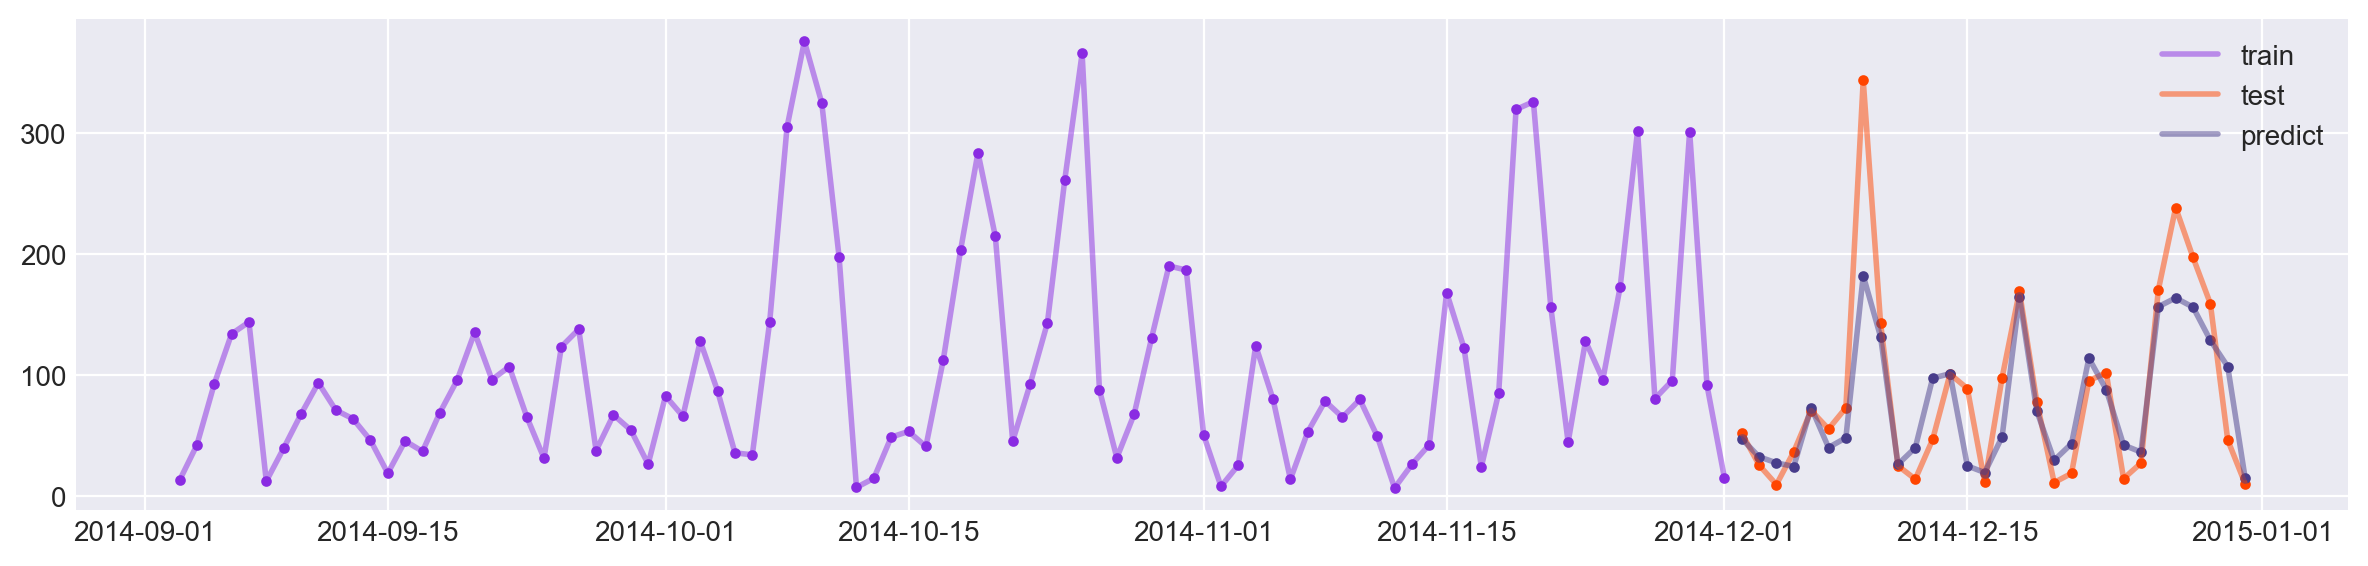

In [62]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [23]:
print(grid_search_results["params"])

{'l2_leaf_reg': 5}


In [63]:
del (
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

### Data Preparation for LSTM

In [25]:
import tensorflow as tf


model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 15


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

data_x, data_y = seperate_target(df_feat, TARGET_COLUMN)

print(f"data_x shape after seperate_target {data_x.shape}")
print(f"data_y shape after seperate_target {data_y.shape}", end="\n\n")

scaler_x = StandardScaler()
scaler_x.fit(data_x)
data_x_np = scaler_x.transform(data_x)

scaler_y = StandardScaler()
scaler_y.fit(data_y)
data_y_np = scaler_y.transform(data_y)

print(f"data_x shape after StandardScaler {data_x_np.shape}")
print(f"data_y shape after StandardScaler {data_y_np.shape}", end="\n\n")

x_window, y_window = window_data(data_x_np, data_y_np, window_len=WINDOW_LEN)

print(f"x_window shape after Windowing {x_window.shape}")
print(f"y_window shape after Windowing {y_window.shape}", end="\n\n")

x_train_data, x_test_data = x_window[:-TEST_SIZE], x_window[-TEST_SIZE:]
y_train_data, y_test_data = y_window[:-TEST_SIZE], y_window[-TEST_SIZE:]

print(f"x_train_data shape after Test Train Split {x_train_data.shape}")
print(f"x_test_data  shape after Test Train Split {x_test_data.shape}")
print(f"y_train_data shape after Test Train Split {y_train_data.shape}")
print(f"y_test_data  shape after Test Train Split {y_test_data.shape}", end="\n\n")

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

dataframe shape (1825, 7)
dataframe shape after Feature Union (1822, 26)

data_x shape after seperate_target (1822, 25)
data_y shape after seperate_target (1822, 1)

data_x shape after StandardScaler (1822, 25)
data_y shape after StandardScaler (1822, 1)

x_window shape after Windowing (1799, 24, 25)
y_window shape after Windowing (1799, 1)

x_train_data shape after Test Train Split (1769, 24, 25)
x_test_data  shape after Test Train Split (30, 24, 25)
y_train_data shape after Test Train Split (1769, 1)
y_test_data  shape after Test Train Split (30, 1)



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = tf.keras.models.Sequential(
    [
        LSTM(64, input_shape=x_window.shape[-2:], dropout=0.0, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1),
    ]
)

model.compile(optimizer="adam", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=25,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

In [ ]:
yhat_scaled = scaler_y.inverse_transform(yhat)
y_test_data_scaled = scaler_y.inverse_transform(y_test_data)
y_train_data_scaled = scaler_y.inverse_transform(y_train_data)


print(f"yhat_scaled shape {yhat_scaled.shape} {y_test_data_scaled.shape}")

In [ ]:
resultsDict[model_name] = evaluate(y_test_data_scaled, yhat_scaled)

In [ ]:
plot_tf_training_history(training_history)

In [ ]:
len(y_train_data_scaled)

In [ ]:
y_hat_df = pd.DataFrame(
    yhat_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_test_data_df = pd.DataFrame(
    y_test_data_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_train_data_df = pd.DataFrame(
    y_train_data_scaled,
    index=data_y.index[WINDOW_LEN - 1 : -TEST_SIZE],
    columns=["TARGET_COLUMN"],
)

show_series(
    [y_train_data_df[-90:], y_test_data_df, y_hat_df],
    labels=["train", "test", "predict"],
)

In [64]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor
mae,57.131944,38.537050,36.243320,29.050693,28.580566,26.150323,26.926116
rmse,76.134798,55.041242,55.166435,45.519325,45.544784,41.022742,41.680117
mape,2.044558,1.149357,0.981606,0.662921,0.621521,0.522270,0.573898
r2,0.047330,0.502088,0.499820,0.659460,0.659079,0.723417,0.714482


In [65]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,57.131944,76.134798,2.044558,0.047330
BayesianRidge,38.537050,55.041242,1.149357,0.502088
LassoCV,36.243320,55.166435,0.981606,0.499820
RandomForestRegressor,29.050693,45.519325,0.662921,0.659460
XGBRegressor,28.580566,45.544784,0.621521,0.659079
LGBMRegressor,26.150323,41.022742,0.522270,0.723417
CatBoostRegressor,26.926116,41.680117,0.573898,0.714482


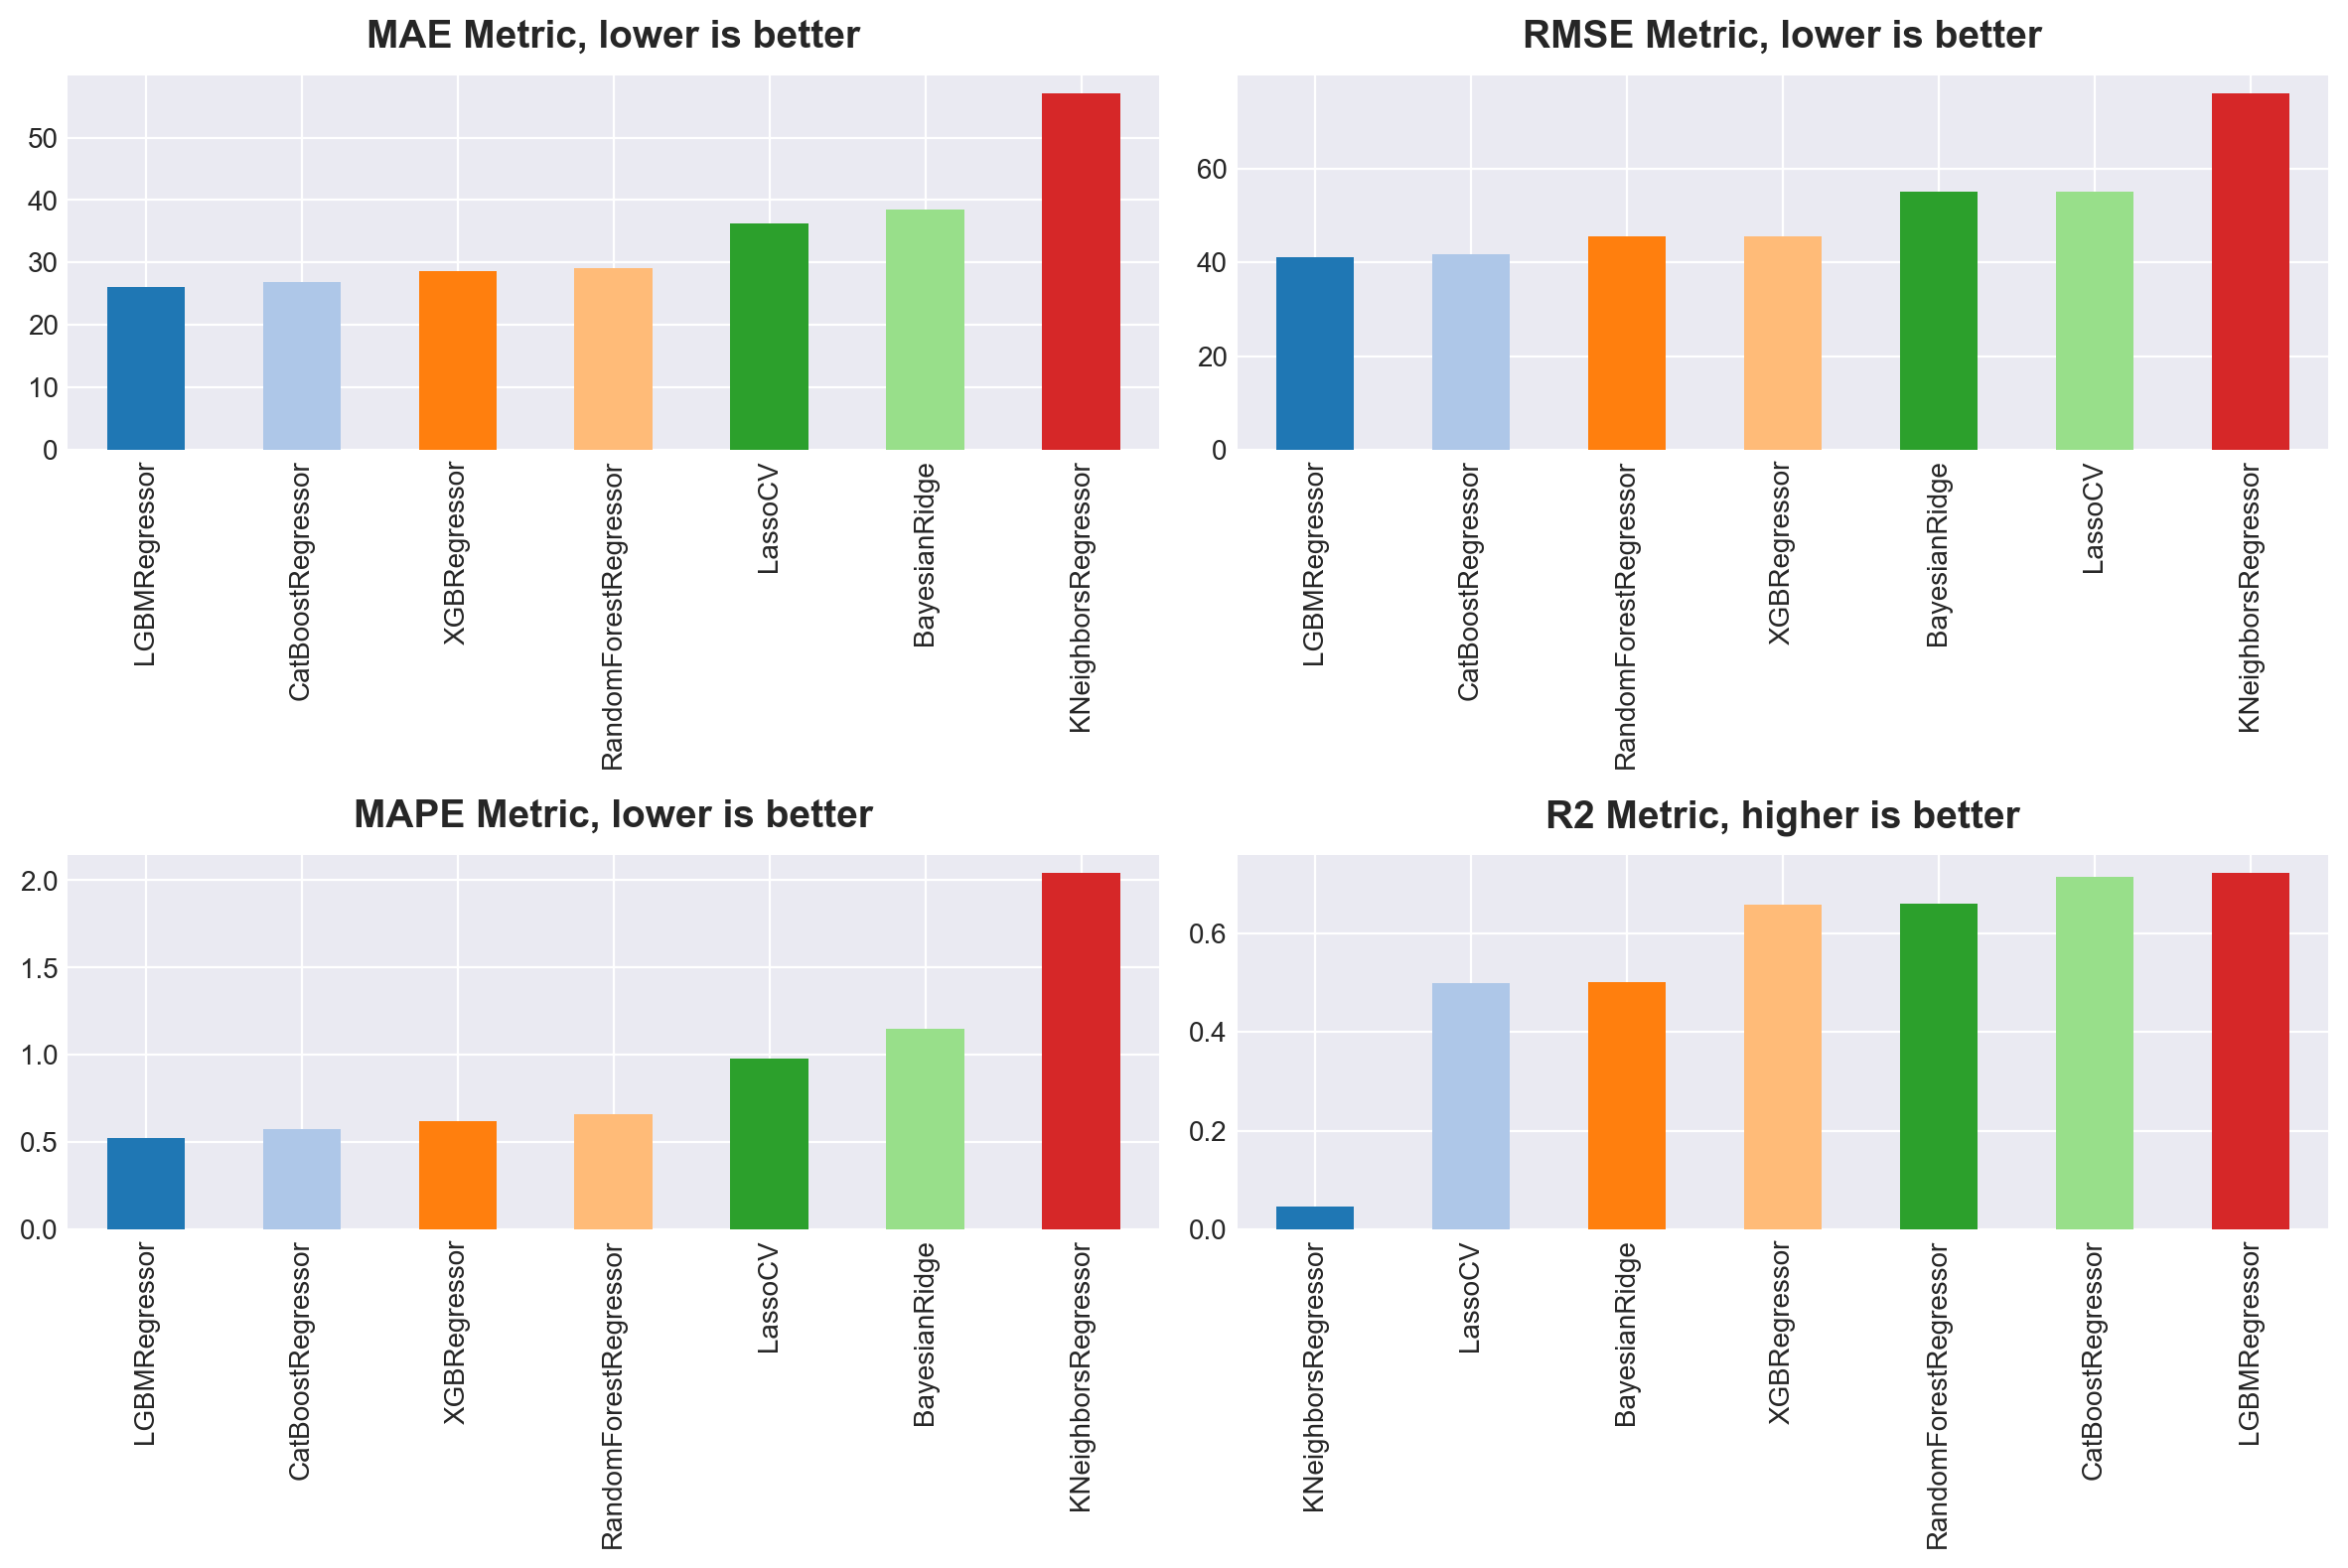

In [66]:
plot_metrics(resultsDF)

In [ ]:
resultsDF_T = resultsDF.T.copy(deep=True)

resultsDF_T["Dataset"] = "Air_Polution"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"


if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Air_Polution"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Air_Polution"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)